In [ ]:
# mounting drive to colab
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install PyWavelets

In [ ]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import csv
import itertools
import collections
import pywt
from scipy import stats
from scipy.signal import butter, lfilter, freqz
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D,Conv2D, AvgPool1D, Flatten, Dense, Dropout, Softmax
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline




In [ ]:
# these lines are setting up some basic styling preferences for your Matplotlib plots, making them appear with the specified size, line properties, and grid.
plt.rcParams["figure.figsize"] = (30,6)
plt.rcParams['lines.linewidth'] = 1
plt.rcParams['lines.color'] = 'b'
plt.rcParams['axes.grid'] = True
#Matplot conditions

In [ ]:
filepath = '/content/drive/MyDrive/Arrhythmia_Detection/mitbih_database/'
window_size = 180  # This variable defines the length of the ECG signal segments that you will be using for analysis. Each segment will be 180 data points long.
maximum_counting = 10000 # This variable sets a limit on the number of ECG segments you will load for each class. This is useful for managing the size of your dataset, especially if you have a large amount of data.

#This list stores the names of the different types of heartbeats you want to classify
# (N: Normal beat, L: Left bundle branch block beat, R: Right bundle branch block beat, A: Atrial premature beat, V: Premature ventricular contraction).
classnames = ['N', 'L', 'R', 'A', 'V']
n_classes = len(classnames)
count_classes = [0]*n_classes

X = list()
y = list()

signaldata = list(): This line creates an empty list named signaldata. This list will be used to store the actual ECG signal data from each file.

annotations = list(): This line creates another empty list called annotations. This list will be used to store the annotations corresponding to each ECG signal, which indicate the types of heartbeats present in the signal.

In [ ]:
filenames = next(os.walk(filepath))[2]
signaldata = list()
annotations = list()
filenames.sort()
print((filenames))

['.DS_Store', '100.csv', '100annotations.txt', '101.csv', '101annotations.txt', '102.csv', '102annotations.txt', '103.csv', '103annotations.txt', '104.csv', '104annotations.txt', '105.csv', '105annotations.txt', '106.csv', '106annotations.txt', '107.csv', '107annotations.txt', '108.csv', '108annotations.txt', '109.csv', '109annotations.txt', '111.csv', '111annotations.txt', '112.csv', '112annotations.txt', '113.csv', '113annotations.txt', '114.csv', '114annotations.txt', '115.csv', '115annotations.txt', '116.csv', '116annotations.txt', '117.csv', '117annotations.txt', '118.csv', '118annotations.txt', '119.csv', '119annotations.txt', '121.csv', '121annotations.txt', '122.csv', '122annotations.txt', '123.csv', '123annotations.txt', '124.csv', '124annotations.txt', '200.csv', '200annotations.txt', '201.csv', '201annotations.txt', '202.csv', '202annotations.txt', '203.csv', '203annotations.txt', '205.csv', '205annotations.txt', '207.csv', '207annotations.txt', '208.csv', '208annotations.tx

In [ ]:
for f in filenames:
    # this function splits the name into the filename and its extension
    filename, file_ext = os.path.splitext(f)

    if(file_ext == '.csv'):
        signaldata.append(filepath + filename + file_ext)

    elif(file_ext == '.txt'):
        annotations.append(filepath + filename + file_ext)

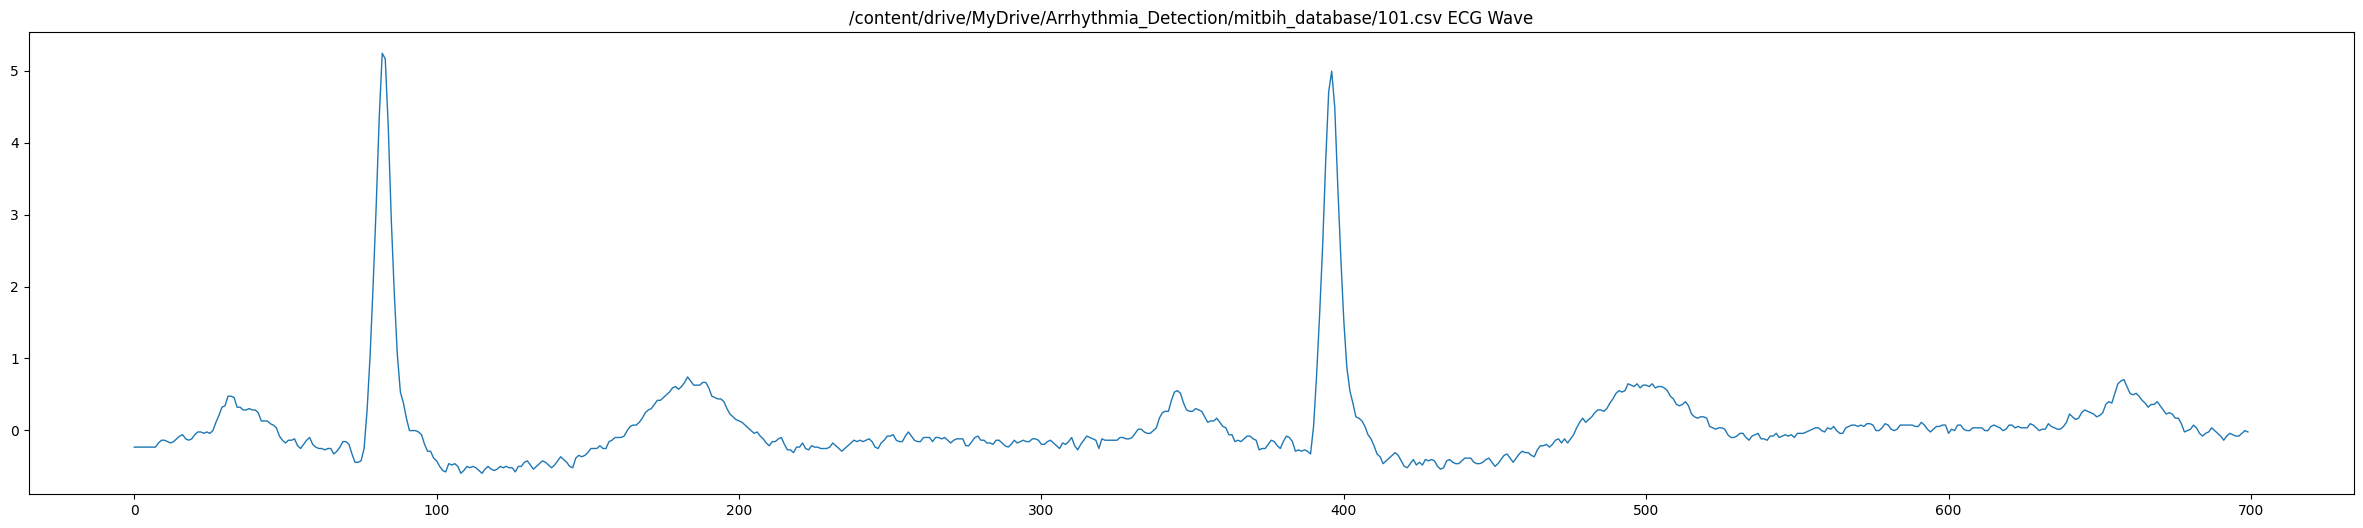

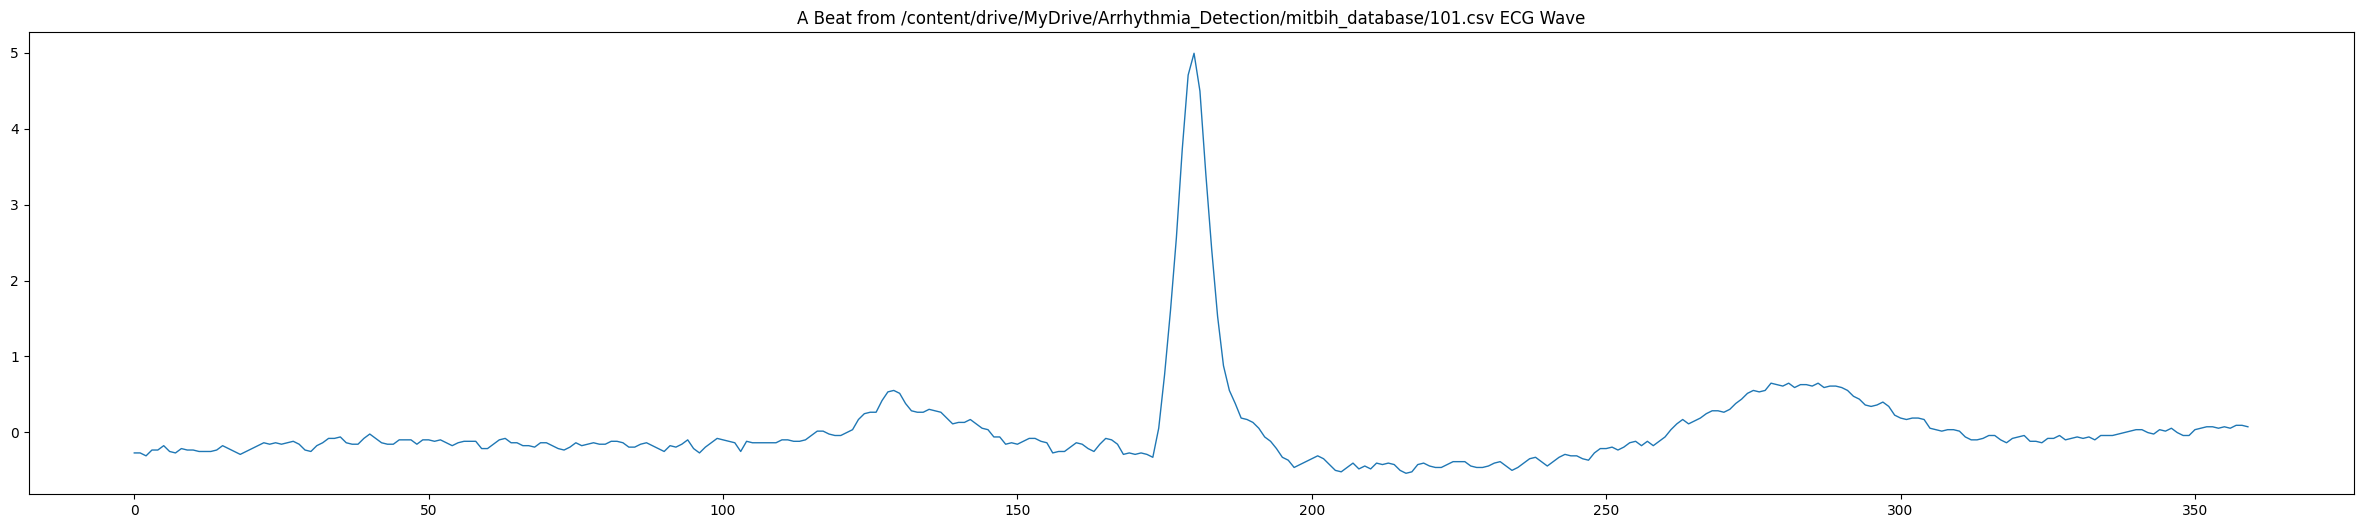

Number of samples for each class: [75052, 8075, 7259, 2546, 7130]


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Parameters
window_size = 180

X = []
y = []

# Loop through each signal and annotation file
for r in range(0, len(signaldata)):
    # Read signal data using pandas
    df = pd.read_csv(signaldata[r])

    # Assuming the second column contains the signal data (like the original code)
    signals = df.iloc[:, 1].astype(int).tolist()

    # Normalize the signals using Z-score normalization
    signals = stats.zscore(signals)

    # Plot the first 700 samples of the signal from the second file for visualization
    if r == 1:
        plt.figure(figsize=(30, 6))
        plt.grid()
        plt.title(f"{signaldata[1]} ECG Wave")
        plt.plot(signals[0:700])
        plt.show()
        sc = signals

    boolvar = False

    # Read annotation data
    with open(annotations[r], 'r') as fileID:
        data = fileID.readlines()

        for d in range(1, len(data)):
            splitted = data[d].split()
            splitted = list(filter(None, splitted))

            # Extract position and class type
            pos = int(splitted[1])
            class_type = splitted[2]


            if class_type in classnames:
                c_ind = classnames.index(class_type)
                count_classes[c_ind] += 1

                # Ensure the window is within bounds of the signal length
                if window_size <= pos < (len(signals) - window_size):
                    beat = signals[pos - window_size: pos + window_size]

                    # Plot the beat from the second signal file for visualization
                    if r == 1 and not boolvar:
                        plt.figure(figsize=(30, 6))
                        plt.grid()
                        plt.title(f"A Beat from {signaldata[1]} ECG Wave")
                        plt.plot(beat)
                        plt.show()
                        boolvar = True

                    # Append the beat segment and its label
                    X.append(beat)
                    y.append(c_ind)

# Convert lists to numpy arrays for further processing
X = np.array(X)
y = np.array(y)

print(f"Number of samples for each class: {count_classes}")


In [ ]:
# Initialize a new list to hold the combined data
combined_X = []

for i in range(len(X)):
    # Append a new array containing the ECG segment and its corresponding class label
    combined_X.append(np.append(X[i], y[i]))

# Convert the list back to a NumPy array if needed
combined_X = np.array(combined_X)
print(np.shape(combined_X))  # Check the shape of the new array


(100012, 361)


360
0.0    75011
1.0     8071
2.0     7255
4.0     7129
3.0     2546
Name: count, dtype: int64


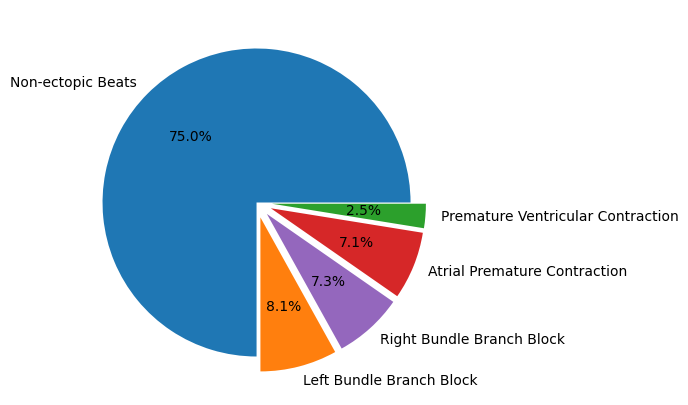

In [ ]:
X_train_df = pd.DataFrame(combined_X)
per_class = X_train_df[X_train_df.shape[1]-1].value_counts()
print(per_class)
plt.figure(figsize=(10, 5))  # Adjusted to make the plot smaller
my_circle=plt.Circle( (0,0), 0.7, color='white')
explode=(0,0.1,0.1,0.1,0.1)
plt.pie(per_class, labels=['Non-ectopic Beats', 'Left Bundle Branch Block', 'Right Bundle Branch Block', 'Atrial Premature Contraction', 'Premature Ventricular Contraction'],explode=explode, colors=['tab:blue','tab:orange','tab:purple','tab:red','tab:green'],autopct='%1.1f%%')
plt.show()

In [ ]:
# @title
target=X_train_df.shape[1]-1
df_0=X_train_df[X_train_df[target]==0]
df_1=X_train_df[X_train_df[target]==1]
df_2=X_train_df[X_train_df[target]==2]
df_3=X_train_df[X_train_df[target]==3]
df_4=X_train_df[X_train_df[target]==4]

In [ ]:
# check the length of all the dfs
print(len(df_0),len(df_1),len(df_2),len(df_3),len(df_4))

75011 8071 7255 2546 7129


In [ ]:
countclassno=2546



df_0_undersample=df_0.sample(countclassno,replace=True)

df_1_undersample=df_1.sample(countclassno,replace=True)
df_2_undersample=df_2.sample(countclassno,replace=True)
df_3_undersample=df_3.sample(countclassno,replace=True)
df_4_undersample=df_4.sample(countclassno,replace=True)

X_train_df=pd.concat([df_0_undersample,df_1_undersample,df_2_undersample,df_3_undersample,df_4_undersample])

360
0.0    2546
1.0    2546
2.0    2546
3.0    2546
4.0    2546
Name: count, dtype: int64


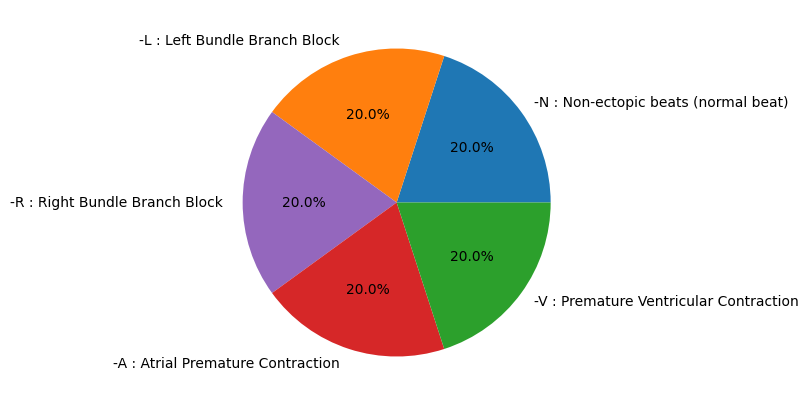

In [ ]:
class_dist = X_train_df[X_train_df.shape[1]-1].value_counts()
print(class_dist)
plt.figure(figsize=(10,5))

plt.pie(class_dist, labels=['-N : Non-ectopic beats (normal beat) ', '-L : Left Bundle Branch Block ', '-R : Right Bundle Branch Block ', '-A : Atrial Premature Contraction ', '-V : Premature Ventricular Contraction'], colors=['tab:blue','tab:orange','tab:purple','tab:red','tab:green'],autopct='%1.1f%%')

plt.show()

In [ ]:
train, test = train_test_split(X_train_df, test_size=0.20,random_state=45637)
print("X_train : ", np.shape(train))
print("X_test  : ", np.shape(test))

X_train :  (10184, 361)
X_test  :  (2546, 361)


In [ ]:
target_train=train[train.shape[1]-1]
target_test=test[test.shape[1]-1]
train_y=to_categorical(target_train)
test_y=to_categorical(target_test)
print(np.shape(train_y), np.shape(test_y))

(10184, 5) (2546, 5)


In [ ]:
train_x = train.iloc[:,:train.shape[1]-1].values
test_x = test.iloc[:,:test.shape[1]-1].values
train_x = train_x.reshape(len(train_x), train_x.shape[1],1)
test_x = test_x.reshape(len(test_x), test_x.shape[1],1)
print(np.shape(train_x), np.shape(test_x))

(10184, 360, 1) (2546, 360, 1)


In [ ]:
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=16, kernel_size=13, padding='same', activation='relu',input_shape=(360, 1)))
cnn_model.add(AvgPool1D(pool_size=3, strides=2))
cnn_model.add(Conv1D(filters=64, kernel_size=17, padding='same', activation='relu'))
cnn_model.add(AvgPool1D(pool_size=3, strides=2))
cnn_model.add(Conv1D(filters=128, kernel_size=19, padding='same', activation='relu'))
cnn_model.add(AvgPool1D(pool_size=3, strides=2))
cnn_model.add(Flatten())
cnn_model.add(Dropout(0.5))
cnn_model.add(Dense(35,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
cnn_model.add(Dense(5,kernel_regularizer=regularizers.l2(0.0001), bias_regularizer=regularizers.l2(0.0001)))
cnn_model.add(Softmax())
cnn_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_3 (Conv1D)                    │ (None, 360, 16)             │             224 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_3                  │ (None, 179, 16)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_4 (Conv1D)                    │ (None, 179, 64)             │          17,472 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_4                  │ (None, 89, 64)              │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 89, 128)             │         155,776 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ average_pooling1d_5                  │ (None, 44, 128)             │               0 │
│ (AveragePooling1D)                   │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 5632)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5632)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 35)                  │         197,155 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 5)                   │             180 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ softmax_1 (Softmax)                  │ (None, 5)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 370,807 (1.41 MB)

 Trainable params: 370,807 (1.41 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:
cnn_history = cnn_model.fit(train_x, train_y, batch_size=36, epochs=30, verbose=1, validation_data=(test_x, test_y))

Epoch 1/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 17s 33ms/step - accuracy: 0.7666 - loss: 0.6345 - val_accuracy: 0.9493 - val_loss: 0.1814
Epoch 2/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step - accuracy: 0.9451 - loss: 0.1754 - val_accuracy: 0.9662 - val_loss: 0.1222
Epoch 3/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.9665 - loss: 0.1214 - val_accuracy: 0.9686 - val_loss: 0.1076
Epoch 4/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - accuracy: 0.9722 - loss: 0.0969 - val_accuracy: 0.9737 - val_loss: 0.1020
Epoch 5/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9753 - loss: 0.0893 - val_accuracy: 0.9753 - val_loss: 0.0942
Epoch 6/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9831 - loss: 0.0702 - val_accuracy: 0.9808 - val_loss: 0.0799
Epoch 7/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9814 - loss: 0.0718 - val_accuracy: 0.9815 - val_loss: 0.0762
Epoch 8/30
283/283 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9824 - loss: 0.0705 - val_accuracy

In [ ]:
cnn_model.save("cnn_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from Google Drive
cnn_model = load_model('/content/drive/MyDrive/Arrhythmia_Detection/Models/cnn_model.h5')
print("Model loaded successfully")


Model loaded successfully


In [ ]:
cnn_model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [ ]:

def evaluate_model(y_true, y_pred):
  """
  This function evaluates the model's performance using common classification metrics.
  Args:
      y_true: The true labels of the data.
      y_pred: The predicted labels from the model.
  Returns:
      None (prints the evaluation results).
  """
  accuracy = accuracy_score(y_true, y_pred)
  precision = precision_score(y_true, y_pred, average='weighted')
  recall = recall_score(y_true, y_pred, average='weighted')
  f1 = f1_score(y_true, y_pred, average='weighted')

  print(f"Accuracy: {accuracy:.4f}")
  print(f"Precision: {precision:.4f}")
  print(f"Recall: {recall:.4f}")
  print(f"F1 Score: {f1:.4f}")
  print('-' * 50)

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from the model
y_pred = cnn_model.predict(test_x)

# If y_pred has multiple output neurons, get the class with highest probability
y_pred = y_pred.argmax(axis=1)

# ... your evaluate_model function ...

# Assuming test_y is one-hot encoded, convert it to multiclass format
test_y_multiclass = np.argmax(test_y, axis=1)

# Evaluate on test data using the converted test_y
evaluate_model(test_y_multiclass, y_pred)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Accuracy: 0.1929
Precision: 0.2249
Recall: 0.1929
F1 Score: 0.1223
--------------------------------------------------


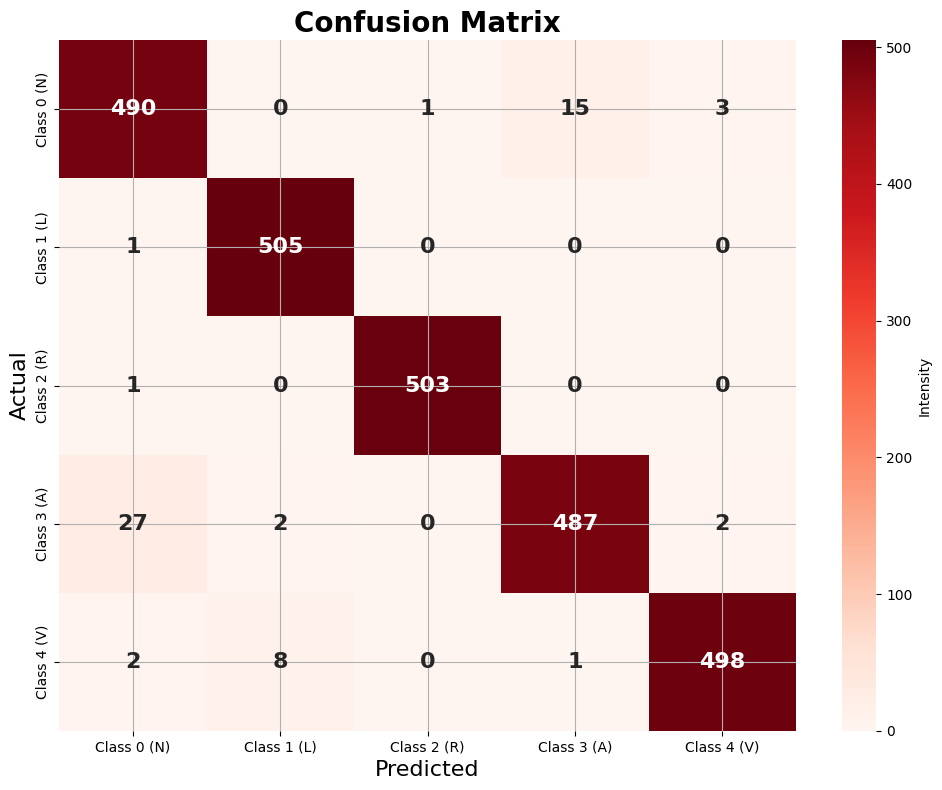

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Confusion matrix data
conf_matrix = np.array([[490, 0, 1, 15, 3],
                        [1, 505, 0, 0, 0],
                        [1, 0, 503, 0, 0],
                        [27, 2, 0, 487, 2],
                        [2, 8, 0, 1, 498]])

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Reds', cbar=True,
            annot_kws={"size": 16, "weight": 'bold'}, # Larger annotations
            cbar_kws={'label': 'Intensity'},  # Add color bar label
            xticklabels=['Class 0 (N)', 'Class 1 (L)', 'Class 2 (R)', 'Class 3 (A)', 'Class 4 (V)'],
            yticklabels=['Class 0 (N)', 'Class 1 (L)', 'Class 2 (R)', 'Class 3 (A)', 'Class 4 (V)'],
            linewidths=0, linecolor='white')  # Remove grid lines

# Add title and labels
plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
plt.xlabel('Predicted', fontsize=16)
plt.ylabel('Actual', fontsize=16)

# Display with a better layout
plt.tight_layout()
plt.show()


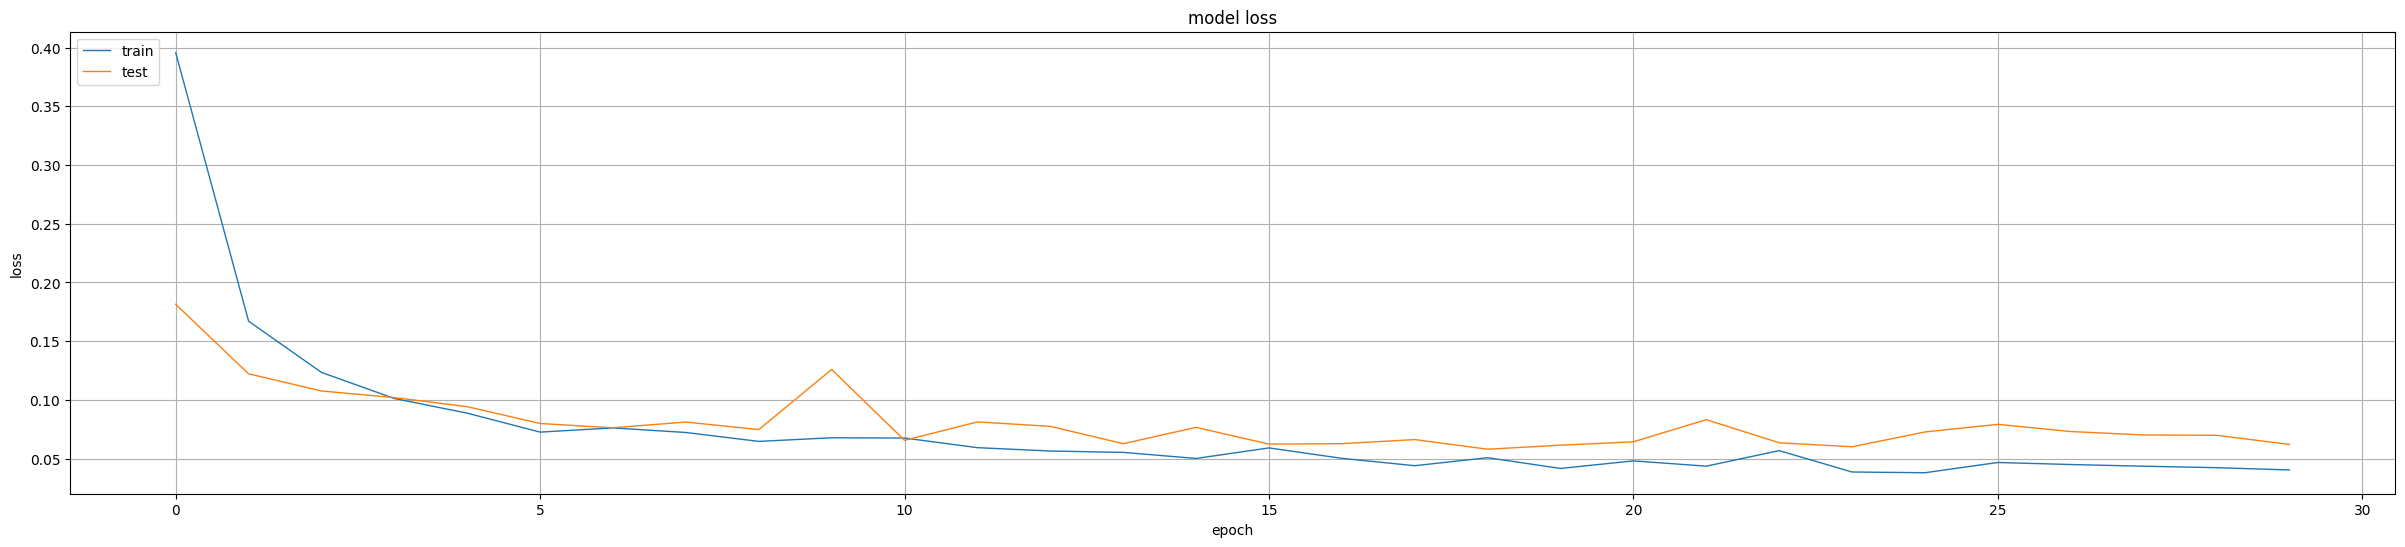

In [ ]:
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

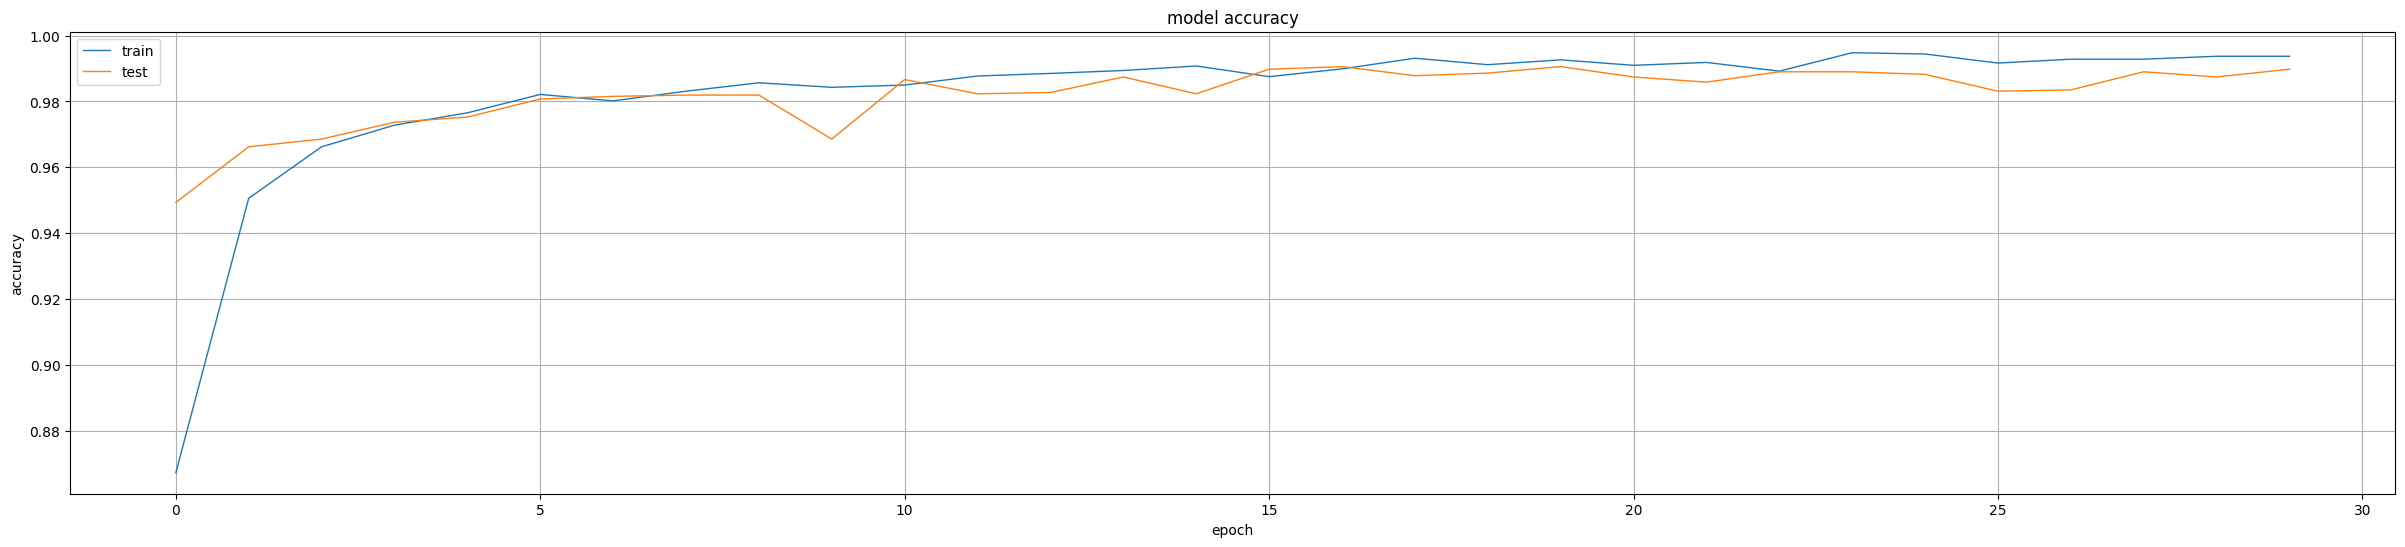

In [ ]:
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

# Define the LSTM model
lstm_model = Sequential()
lstm_model.add(LSTM(128, input_shape=(train_x.shape[1], 1), return_sequences=True))
lstm_model.add(LSTM(64))
lstm_model.add(Dense(35, activation='relu'))
lstm_model.add(Dense(5, activation='softmax'))

# Compile the model
lstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Fit the model
lstm_history = lstm_model.fit(train_x, train_y, epochs=30, batch_size=64, validation_data=(test_x, test_y))


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 360, 128)            │          66,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 35)                  │           2,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 5)                   │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 118,423 (462.59 KB)

 Trainable params: 118,423 (462.59 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.3002 - loss: 1.5402 - val_accuracy: 0.4423 - val_loss: 1.3844
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.4531 - loss: 1.3348 - val_accuracy: 0.5479 - val_loss: 1.1877
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 36ms/step - accuracy: 0.5504 - loss: 1.1609 - val_accuracy: 0.6430 - val_loss: 0.9722
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.3444 - loss: 1.5129 - val_accuracy: 0.4340 - val_loss: 1.3144
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 6s 34ms/step - accuracy: 0.5180 - loss: 1.2313 - val_accuracy: 0.5915 - val_loss: 1.0771
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 32ms/step - accuracy: 0.6250 - loss: 1.0079 - val_accuracy: 0.6638 - val_loss: 0.9031
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.6934 - loss: 0.8531 - val_accuracy: 0.6559 - val_loss: 0.9528
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 34ms/step - accuracy: 0.6665 - loss: 0.9185 - val_ac

In [ ]:
lstm_model.save("lstm_model.h5")
print("Saved model to disk")

Saved model to disk


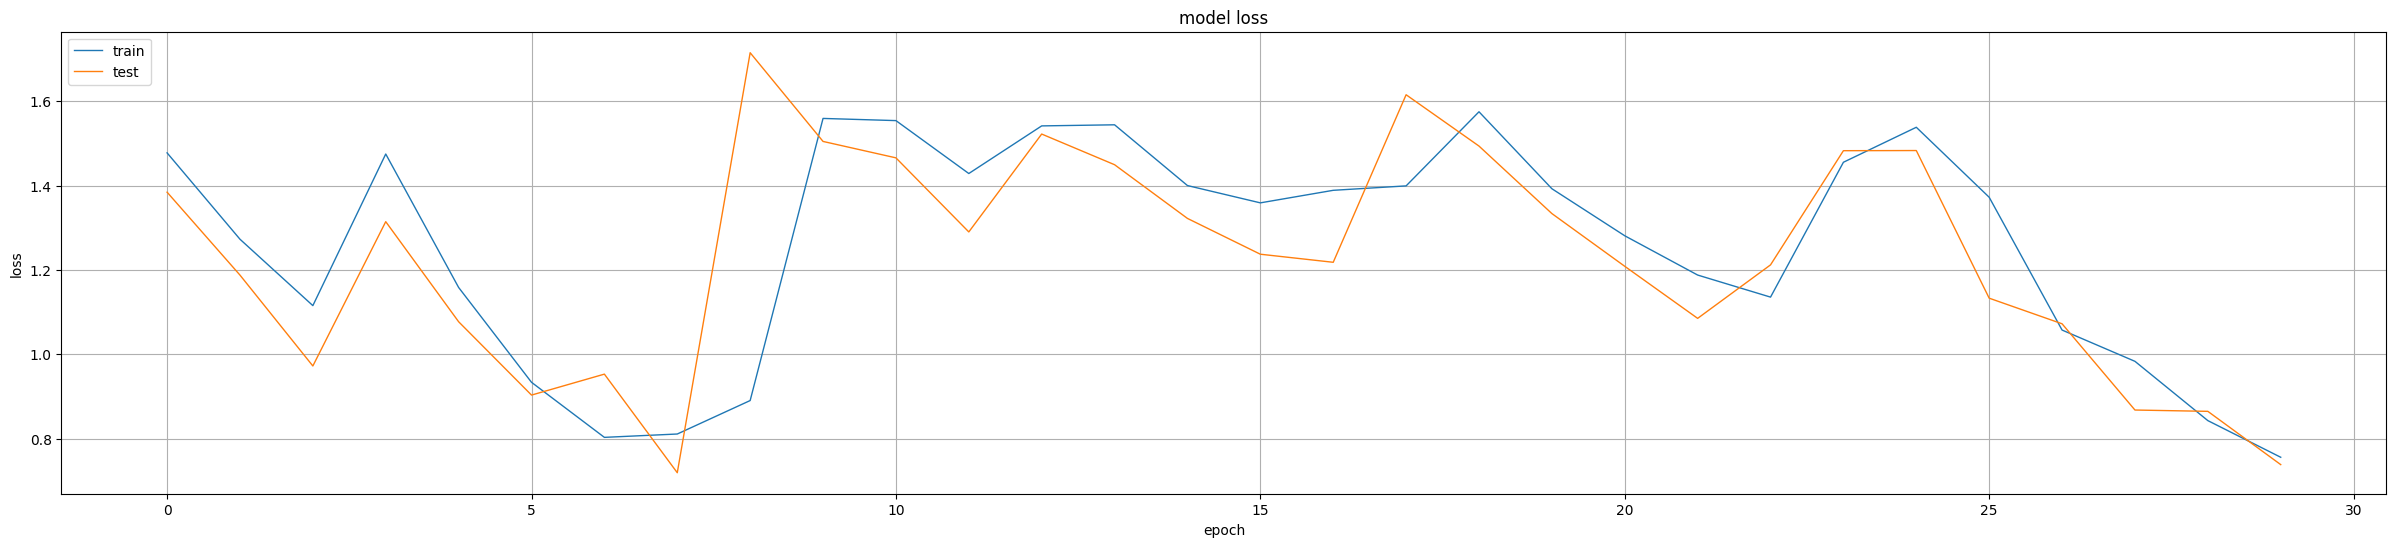

In [ ]:
plt.plot(lstm_history.history['loss'])
plt.plot(lstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

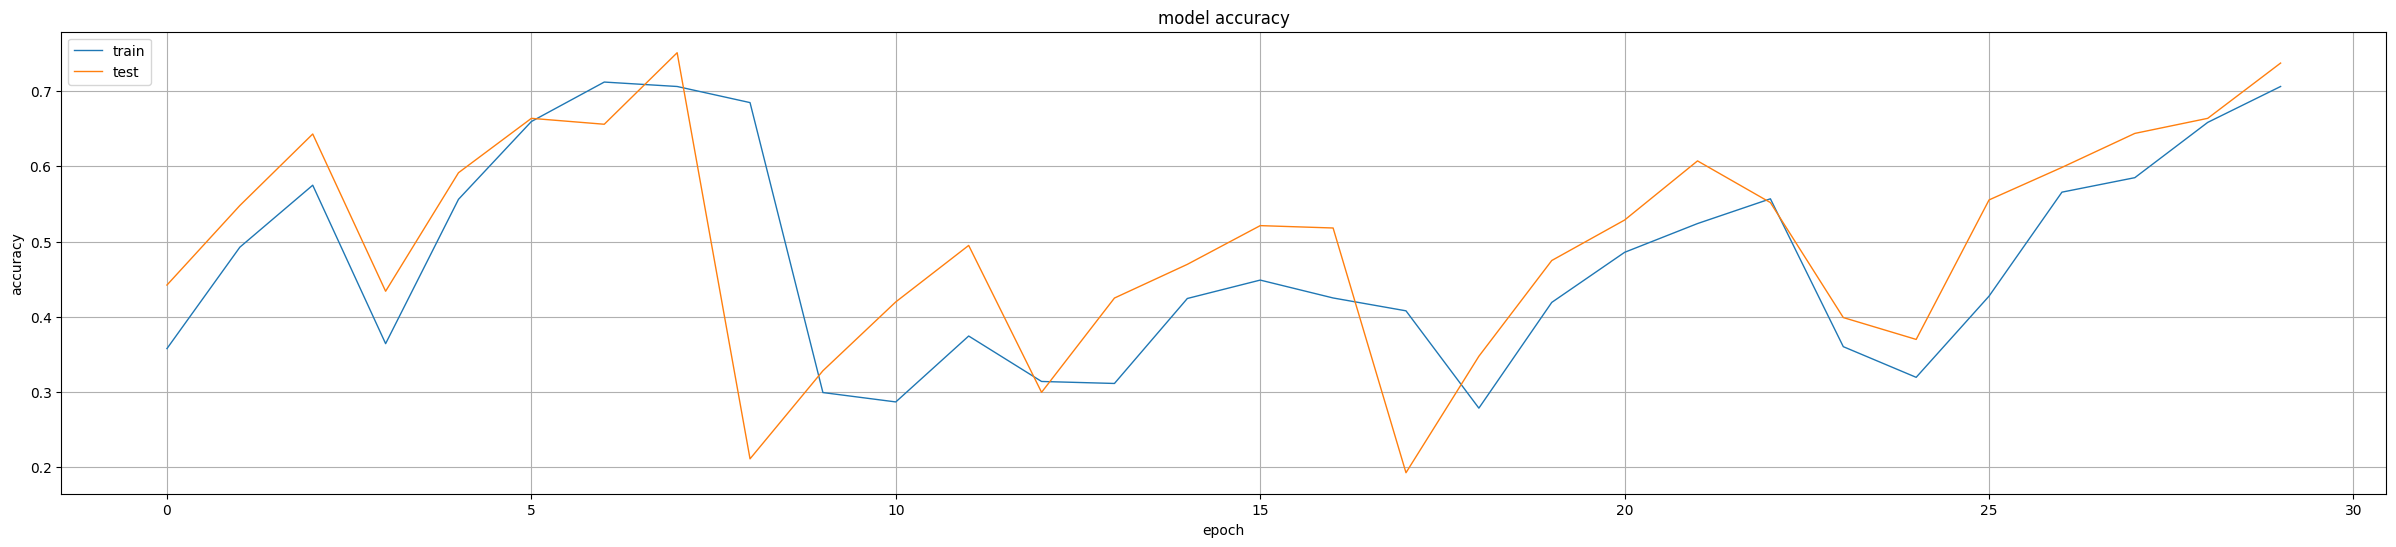

In [ ]:
plt.plot(lstm_history.history['accuracy'])
plt.plot(lstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Bidirectional LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Bidirectional

# Define the BiLSTM model
bilstm_model = Sequential()
bilstm_model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(train_x.shape[1], 1)))
bilstm_model.add(Bidirectional(LSTM(32)))
bilstm_model.add(Dense(35, activation='relu'))
bilstm_model.add(Dense(5, activation='softmax'))

# Compile the model
bilstm_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
bilstm_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)        │ (None, 360, 128)            │          33,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 35)                  │           2,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 77,463 (302.59 KB)

 Trainable params: 77,463 (302.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
bilstm_history = bilstm_model.fit(train_x, train_y, epochs=30, batch_size=64, validation_data=(test_x, test_y))


Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 12s 57ms/step - accuracy: 0.3811 - loss: 1.4579 - val_accuracy: 0.5746 - val_loss: 1.0714
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.5624 - loss: 1.0877 - val_accuracy: 0.6332 - val_loss: 0.9463
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.6784 - loss: 0.8643 - val_accuracy: 0.7490 - val_loss: 0.6878
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 54ms/step - accuracy: 0.7350 - loss: 0.7076 - val_accuracy: 0.7671 - val_loss: 0.6518
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 53ms/step - accuracy: 0.7529 - loss: 0.6869 - val_accuracy: 0.7573 - val_loss: 0.6524
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 51ms/step - accuracy: 0.7288 - loss: 0.7302 - val_accuracy: 0.7541 - val_loss: 0.6545
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 53ms/step - accuracy: 0.7602 - loss: 0.6426 - val_accuracy: 0.4179 - val_loss: 1.3326
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 9s 58ms/step - accuracy: 0.5189 - loss: 1.1432 - val_

In [ ]:
bilstm_model.save("bilstm_model.h5")
print("Saved model to disk")

Saved model to disk


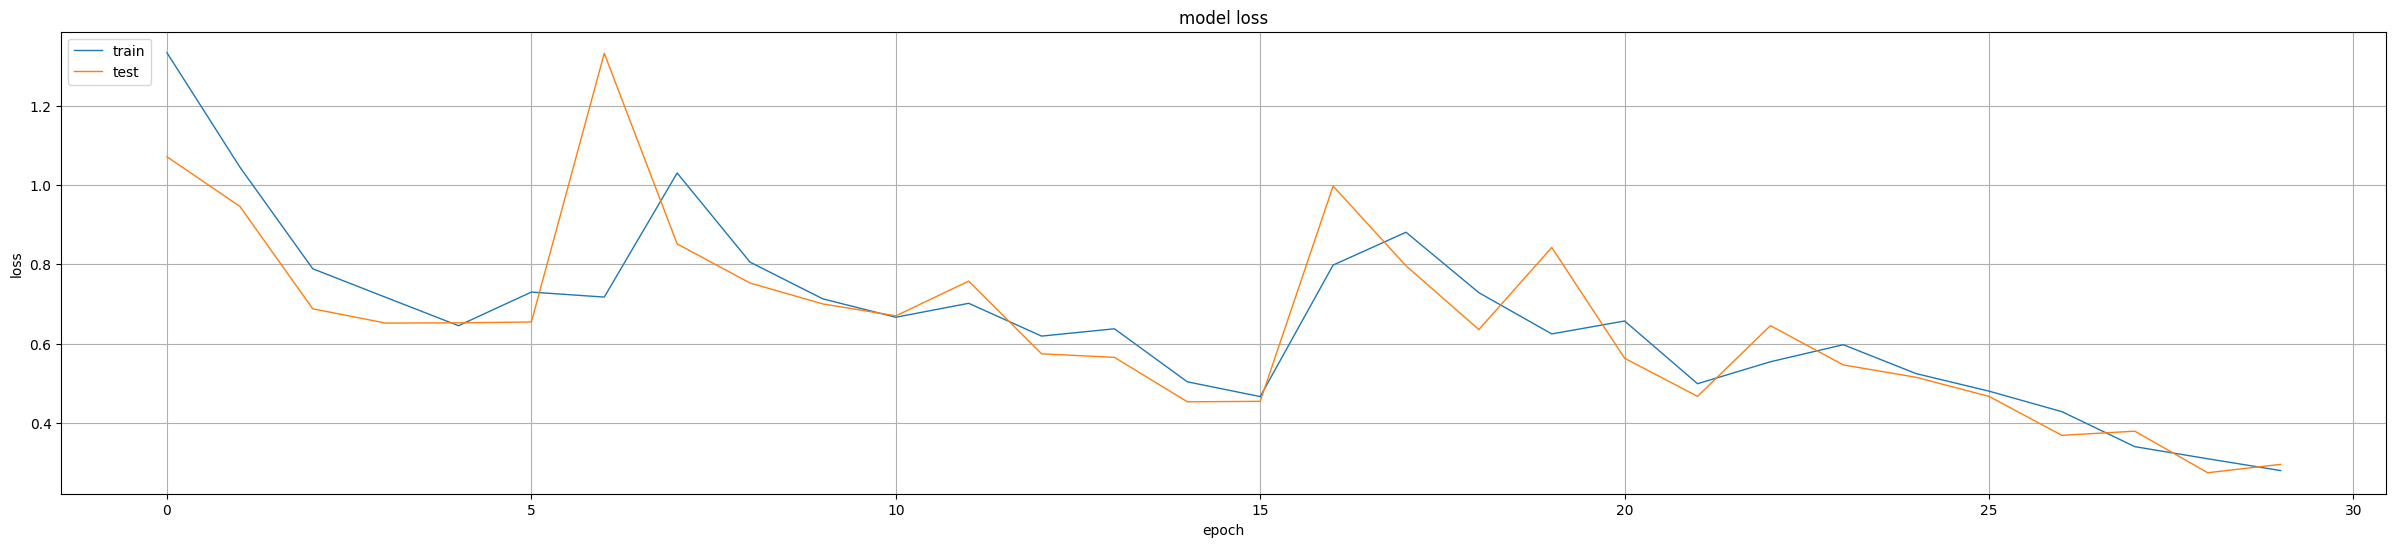

In [ ]:
plt.plot(bilstm_history.history['loss'])
plt.plot(bilstm_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

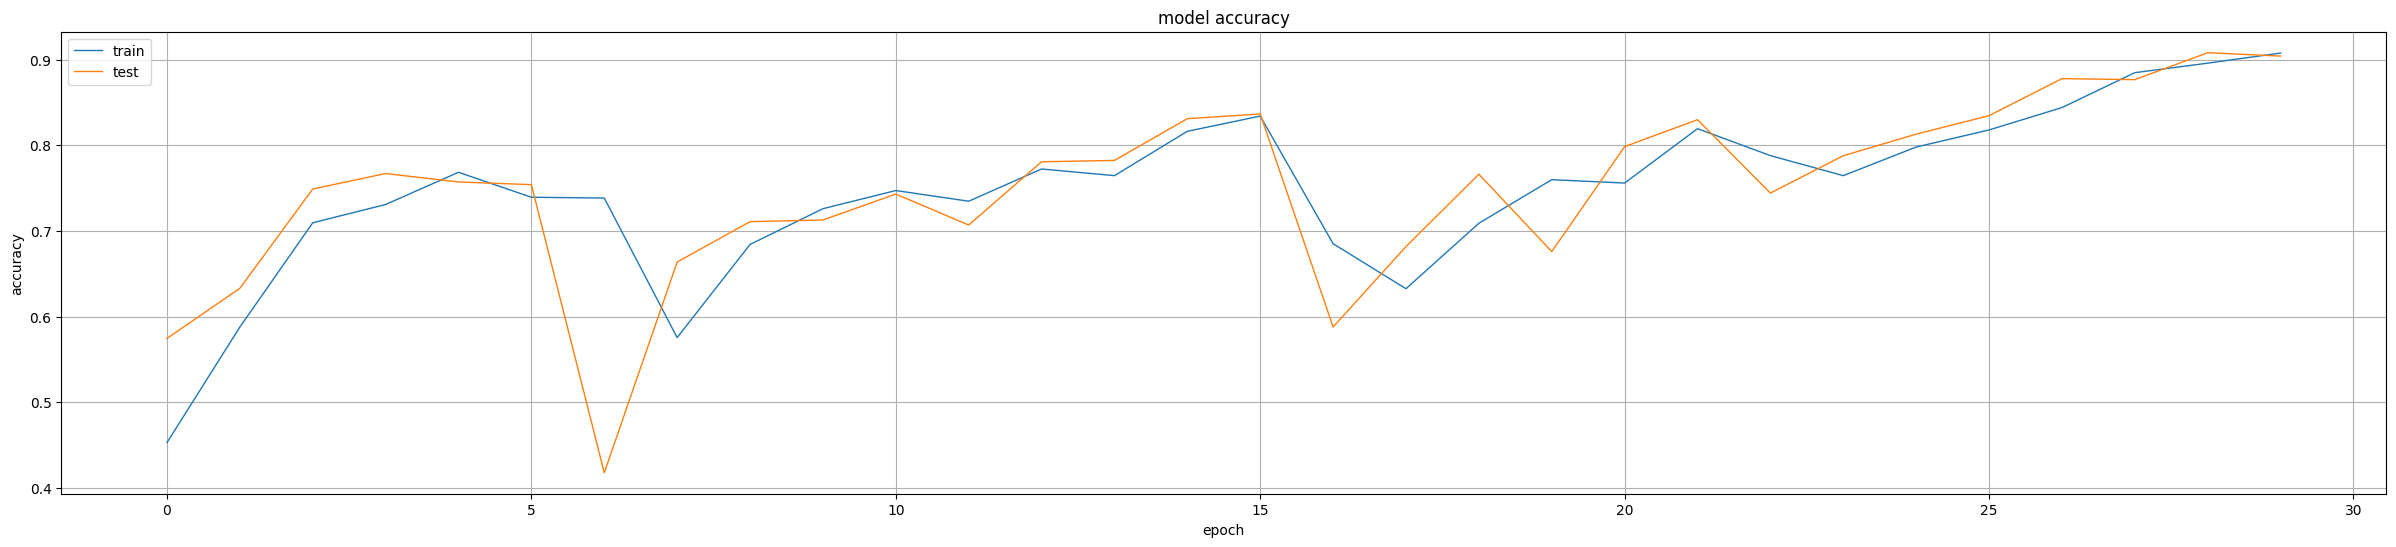

In [ ]:
plt.plot(bilstm_history.history['accuracy'])
plt.plot(bilstm_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()



# Gated Recurrent Unit (GRU) Model

In [ ]:
from keras.models import Sequential
from keras.layers import GRU, Dense

# Define the GRU model
gru_model = Sequential()
gru_model.add(GRU(128, input_shape=(train_x.shape[1], 1), return_sequences=True))
gru_model.add(GRU(64))
gru_model.add(Dense(35, activation='relu'))
gru_model.add(Dense(5, activation='softmax'))

# Compile the model
gru_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
gru_model.summary()



Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 360, 128)            │          50,304 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          37,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 35)                  │           2,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 5)                   │             180 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,007 (351.59 KB)

 Trainable params: 90,007 (351.59 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
gru_history = gru_model.fit(train_x, train_y, epochs=30, batch_size=64, validation_data=(test_x, test_y))


Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - accuracy: 0.2616 - loss: 1.5827 - val_accuracy: 0.3335 - val_loss: 1.5294
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 29ms/step - accuracy: 0.3189 - loss: 1.5385 - val_accuracy: 0.3543 - val_loss: 1.4838
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.3455 - loss: 1.4964 - val_accuracy: 0.4144 - val_loss: 1.3890
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.4259 - loss: 1.3689 - val_accuracy: 0.6178 - val_loss: 0.9392
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.6398 - loss: 0.8911 - val_accuracy: 0.7463 - val_loss: 0.6665
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - accuracy: 0.7624 - loss: 0.6377 - val_accuracy: 0.7969 - val_loss: 0.5734
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 30ms/step - accuracy: 0.8003 - loss: 0.5497 - val_accuracy: 0.8342 - val_loss: 0.4784
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8348 - loss: 0.4802 - val_accu

In [ ]:
gru_model.save("gru_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
from tensorflow.keras.models import load_model

# Load the model from Google Drive
cnn_model = load_model('/content/drive/MyDrive/Arrhythmia_Detection/Models/gru_model.h5')
print("Model loaded successfully")


Model loaded successfully


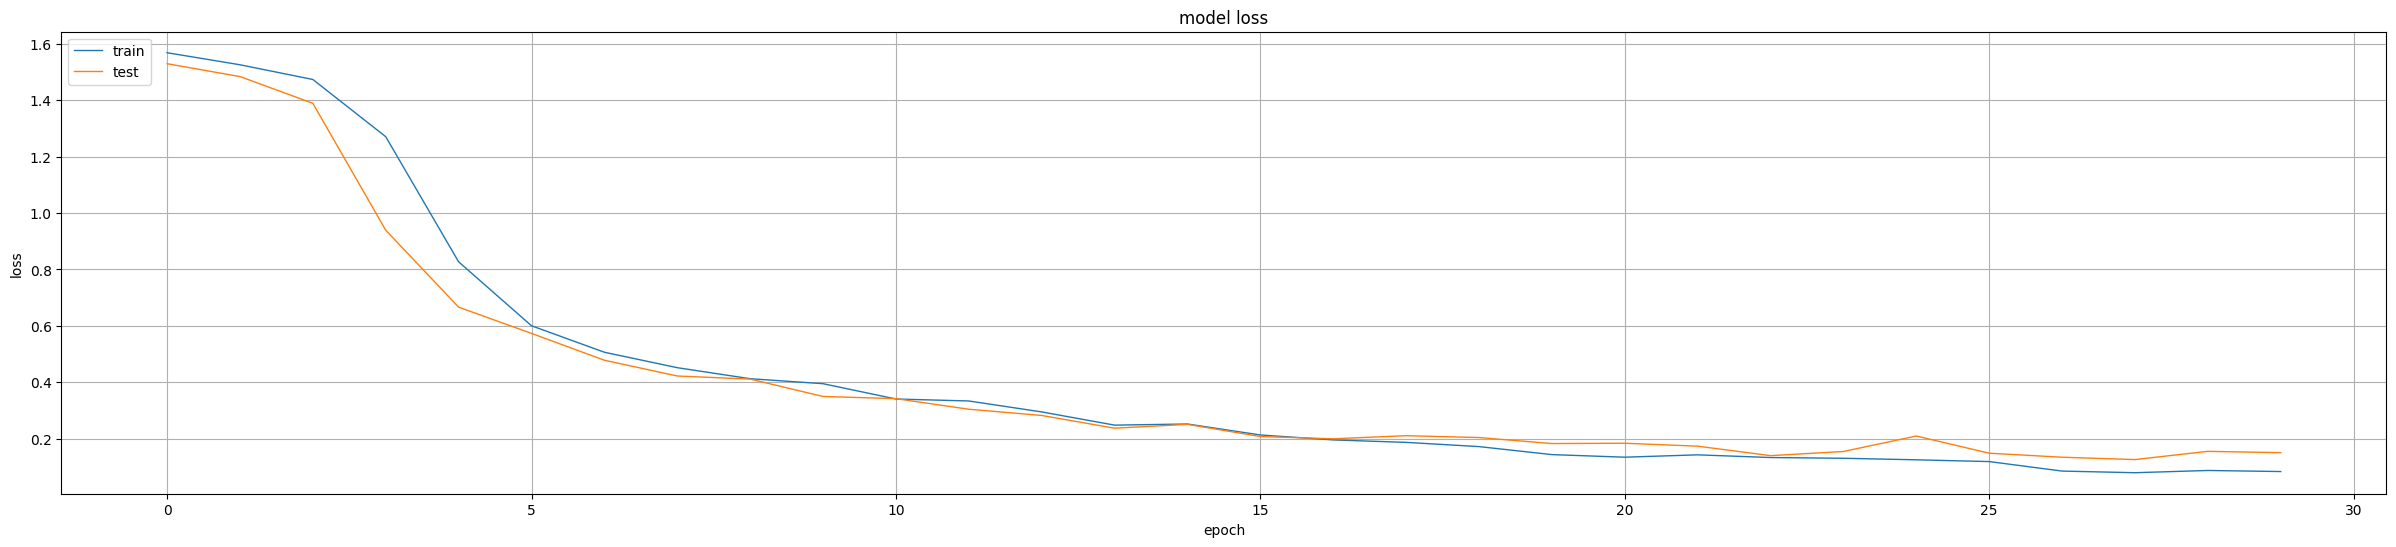

In [ ]:
plt.plot(gru_history.history['loss'])
plt.plot(gru_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

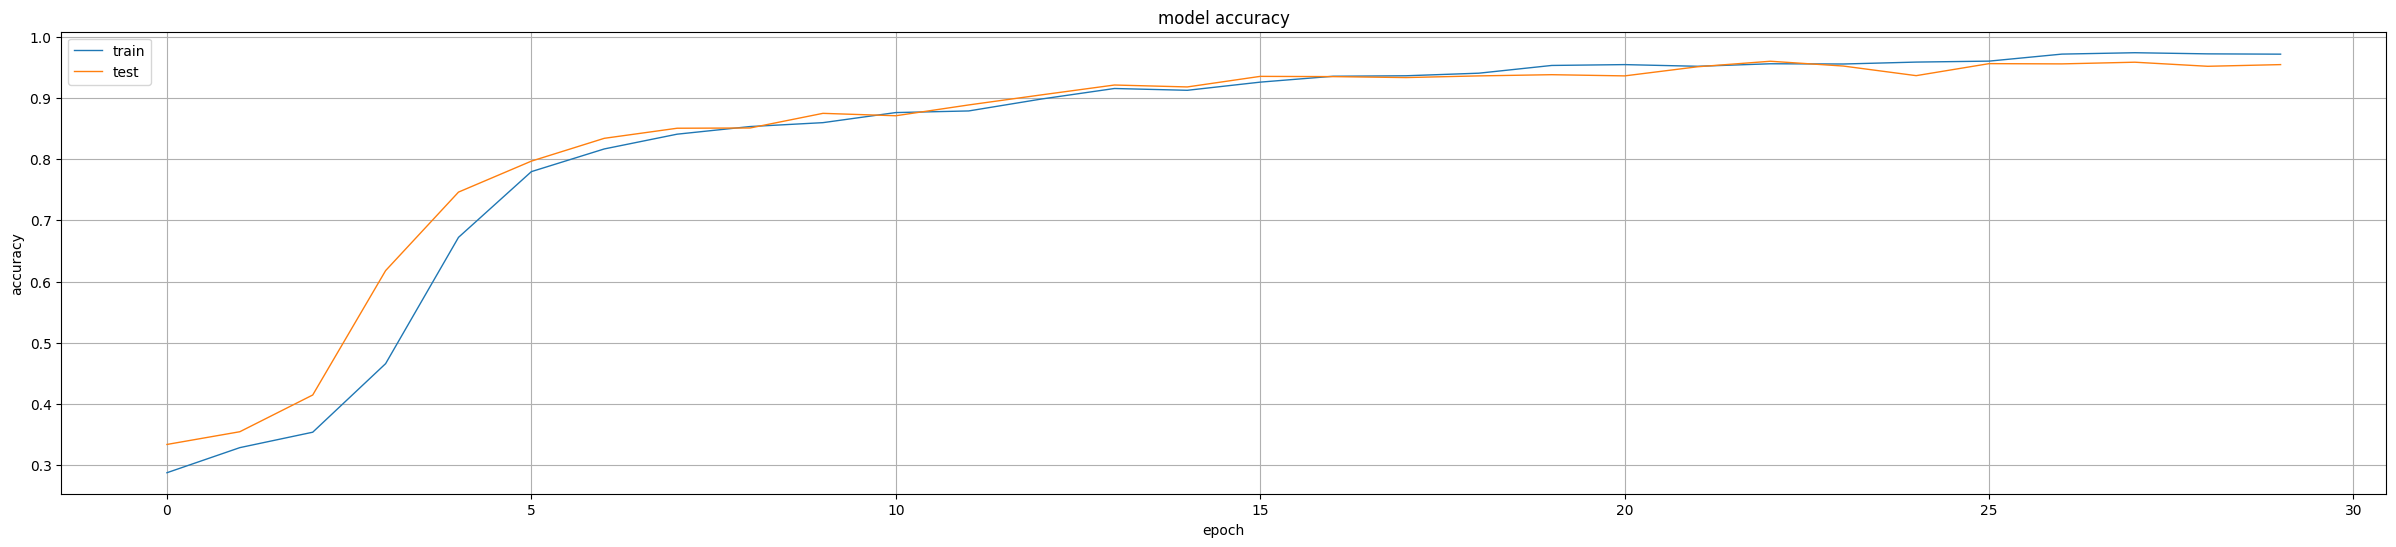

In [ ]:
plt.plot(gru_history.history['accuracy'])
plt.plot(gru_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
from tensorflow.keras.models import load_model
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt

# Get predictions from the model
y_pred = gru_model.predict(test_x)

# If y_pred has multiple output neurons, get the class with highest probability
y_pred = y_pred.argmax(axis=1)

# ... your evaluate_model function ...

# Assuming test_y is one-hot encoded, convert it to multiclass format
test_y_multiclass = np.argmax(test_y, axis=1)

# Evaluate on test data using the converted test_y
evaluate_model(test_y_multiclass, y_pred)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step
Accuracy: 0.9548
Precision: 0.9554
Recall: 0.9548
F1 Score: 0.9548
--------------------------------------------------


80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
Confusion Matrix Values:
[[483   4   4   8  10]
 [  1 500   0   1   4]
 [  3   2 495   3   1]
 [ 37   4   0 470   7]
 [  6  15   0   5 483]]


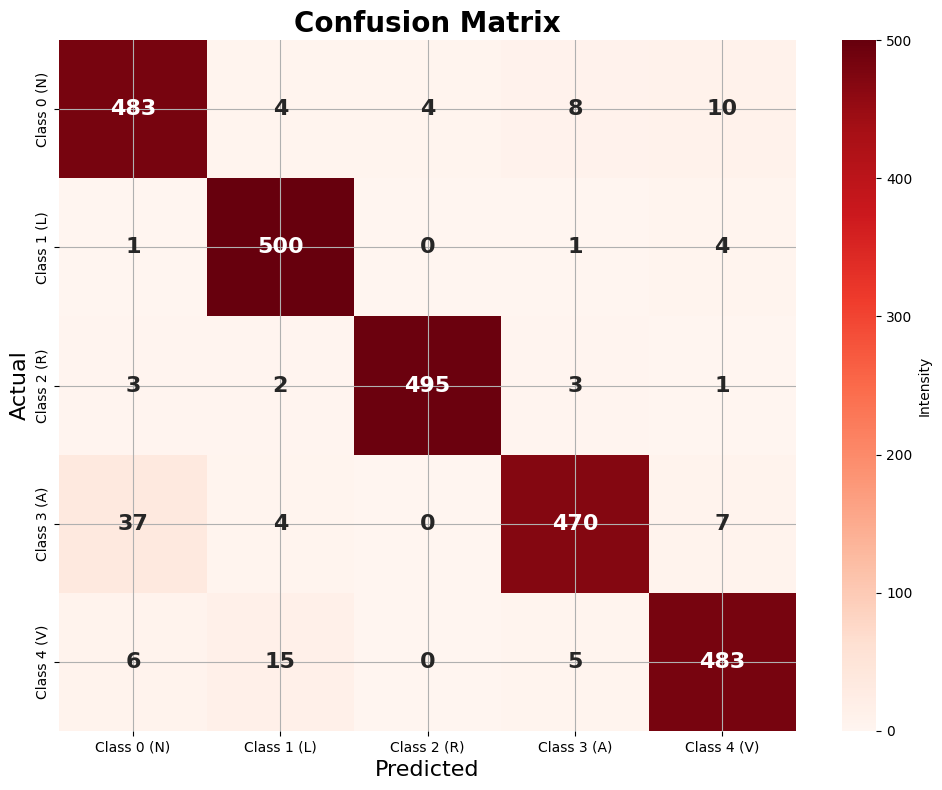

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

def get_confusion_matrix(model, test_x, test_y):
    # Get predictions
    y_pred = model.predict(test_x)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true_classes = np.argmax(test_y, axis=1)

    # Calculate confusion matrix
    cm = confusion_matrix(y_true_classes, y_pred_classes)

    # Print the raw confusion matrix values
    print("Confusion Matrix Values:")
    print(cm)

    # Create a heatmap using seaborn
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Reds', cbar=True,
                annot_kws={"size": 16, "weight": 'bold'},
                cbar_kws={'label': 'Intensity'},
                xticklabels=['Class 0 (N)', 'Class 1 (L)', 'Class 2 (R)', 'Class 3 (A)', 'Class 4 (V)'],
                yticklabels=['Class 0 (N)', 'Class 1 (L)', 'Class 2 (R)', 'Class 3 (A)', 'Class 4 (V)'],
                linewidths=0, linecolor='white')

    # Add title and labels
    plt.title('Confusion Matrix', fontsize=20, fontweight='bold')
    plt.xlabel('Predicted', fontsize=16)
    plt.ylabel('Actual', fontsize=16)

    # Display with a better layout
    plt.tight_layout()
    plt.show()

    return cm

# Example usage for any model (GRU, CNN, LSTM, etc.):
confusion_matrix_values = get_confusion_matrix(gru_model, test_x, test_y)

80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
Confusion Matrix Values:
[[468   2   3  26  10]
 [  2 498   1   1   4]
 [  6   0 496   1   1]
 [ 58   3   9 447   1]
 [ 17  18   4   5 465]]


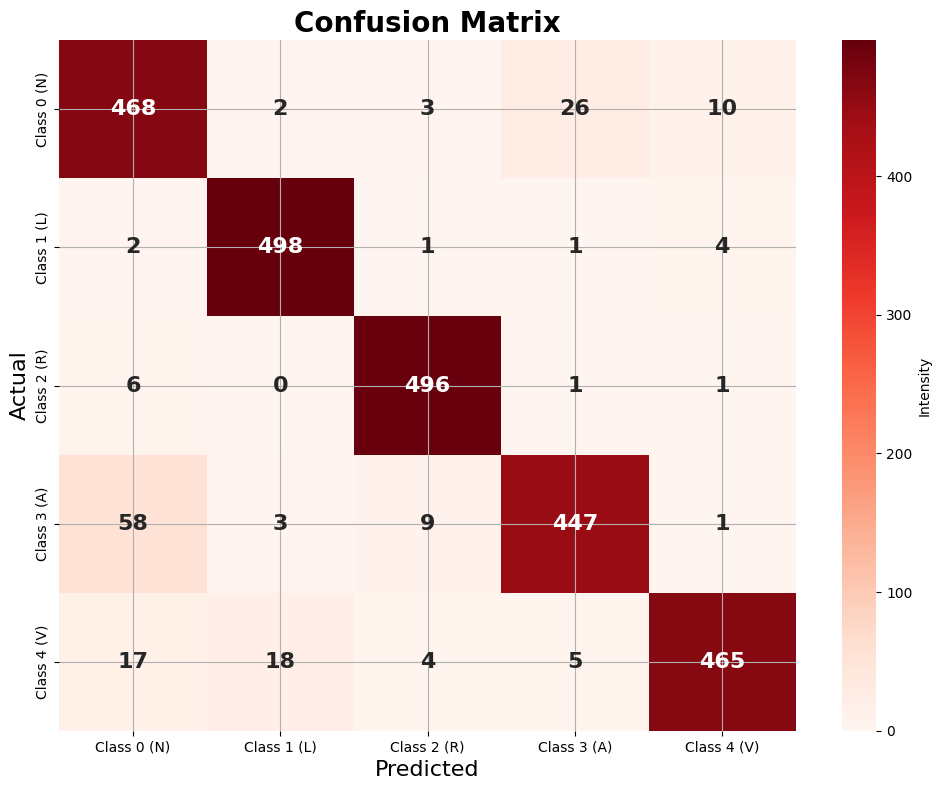

In [ ]:
confusion_matrix_values = get_confusion_matrix(cnn_model, test_x, test_y)

#  1D ResNet Model (Residual Network)

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense


In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, BatchNormalization, Activation, Add, GlobalAveragePooling1D, Dense

def residual_block(x, filters, kernel_size, strides=1):
    # Shortcut connection
    shortcut = x

    # Main path
    x = Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv1D(filters, kernel_size=kernel_size, strides=1, padding='same')(x)
    x = BatchNormalization()(x)

    # If the input and output dimensions do not match, use a 1x1 conv in the shortcut
    if shortcut.shape[-1] != x.shape[-1]:
        shortcut = Conv1D(filters, kernel_size=1, strides=strides, padding='same')(shortcut)

    # Add the shortcut to the main path
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

def build_resnet_1d(input_shape, num_classes):
    inputs = Input(shape=input_shape)

    # Initial Conv layer
    x = Conv1D(64, kernel_size=7, strides=2, padding='same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Residual blocks
    x = residual_block(x, filters=64, kernel_size=3)
    x = residual_block(x, filters=128, kernel_size=3, strides=2)
    x = residual_block(x, filters=256, kernel_size=3, strides=2)

    # Global Average Pooling and output
    x = GlobalAveragePooling1D()(x)
    x = Dense(128, activation='relu')(x)
    outputs = Dense(num_classes, activation='softmax')(x)

    model = Model(inputs, outputs)
    return model

# Define input shape and number of classes
input_shape = (360, 1)  # Adjust this according to your data
num_classes = 5

# Build the ResNet model
resnet_1d_model = build_resnet_1d(input_shape=input_shape, num_classes=num_classes)

# Compile the model
resnet_1d_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
resnet_1d_model.summary()


Model: "functional_64"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 360, 1)         │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_6 (Conv1D)         │ (None, 180, 64)        │            512 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 180, 64)        │            256 │ conv1d_6[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 180, 64)        │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_7 (Conv1D)         │ (None, 180, 64)        │         12,352 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 180, 64)        │            256 │ conv1d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 180, 64)        │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_8 (Conv1D)         │ (None, 180, 64)        │         12,352 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 180, 64)        │            256 │ conv1d_8[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add (Add)                 │ (None, 180, 64)        │              0 │ batch_normalization_2… │
│                           │                        │                │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 180, 64)        │              0 │ add[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_9 (Conv1D)         │ (None, 90, 128)        │         24,704 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 90, 128)        │            512 │ conv1d_9[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 90, 128)        │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_10 (Conv1D)        │ (None, 90, 128)        │         49,280 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 90, 128)        │            512 │ conv1d_10[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 473,349 (1.81 MB)

 Trainable params: 471,429 (1.80 MB)

 Non-trainable params: 1,920 (7.50 KB)

In [ ]:
# Train the model for 30 epochs
resnet_1d_history = resnet_1d_model.fit(train_x, train_y, epochs=30, batch_size=32, validation_data=(test_x, test_y))



Epoch 1/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 19s 27ms/step - accuracy: 0.7313 - loss: 0.7854 - val_accuracy: 0.6936 - val_loss: 0.7863
Epoch 2/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.8930 - loss: 0.3108 - val_accuracy: 0.9175 - val_loss: 0.2567
Epoch 3/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - accuracy: 0.9127 - loss: 0.2440 - val_accuracy: 0.9415 - val_loss: 0.1723
Epoch 4/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9334 - loss: 0.1821 - val_accuracy: 0.9352 - val_loss: 0.1896
Epoch 5/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9458 - loss: 0.1461 - val_accuracy: 0.9254 - val_loss: 0.2246
Epoch 6/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.9546 - loss: 0.1247 - val_accuracy: 0.9262 - val_loss: 0.2033
Epoch 7/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9589 - loss: 0.1100 - val_accuracy: 0.9599 - val_loss: 0.1264
Epoch 8/30
319/319 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9674 - loss: 0.0904 - val_accuracy: 

In [ ]:
resnet_1d_model.save("resnet_1d_model.h5")
print("Saved model to disk")

Saved model to disk


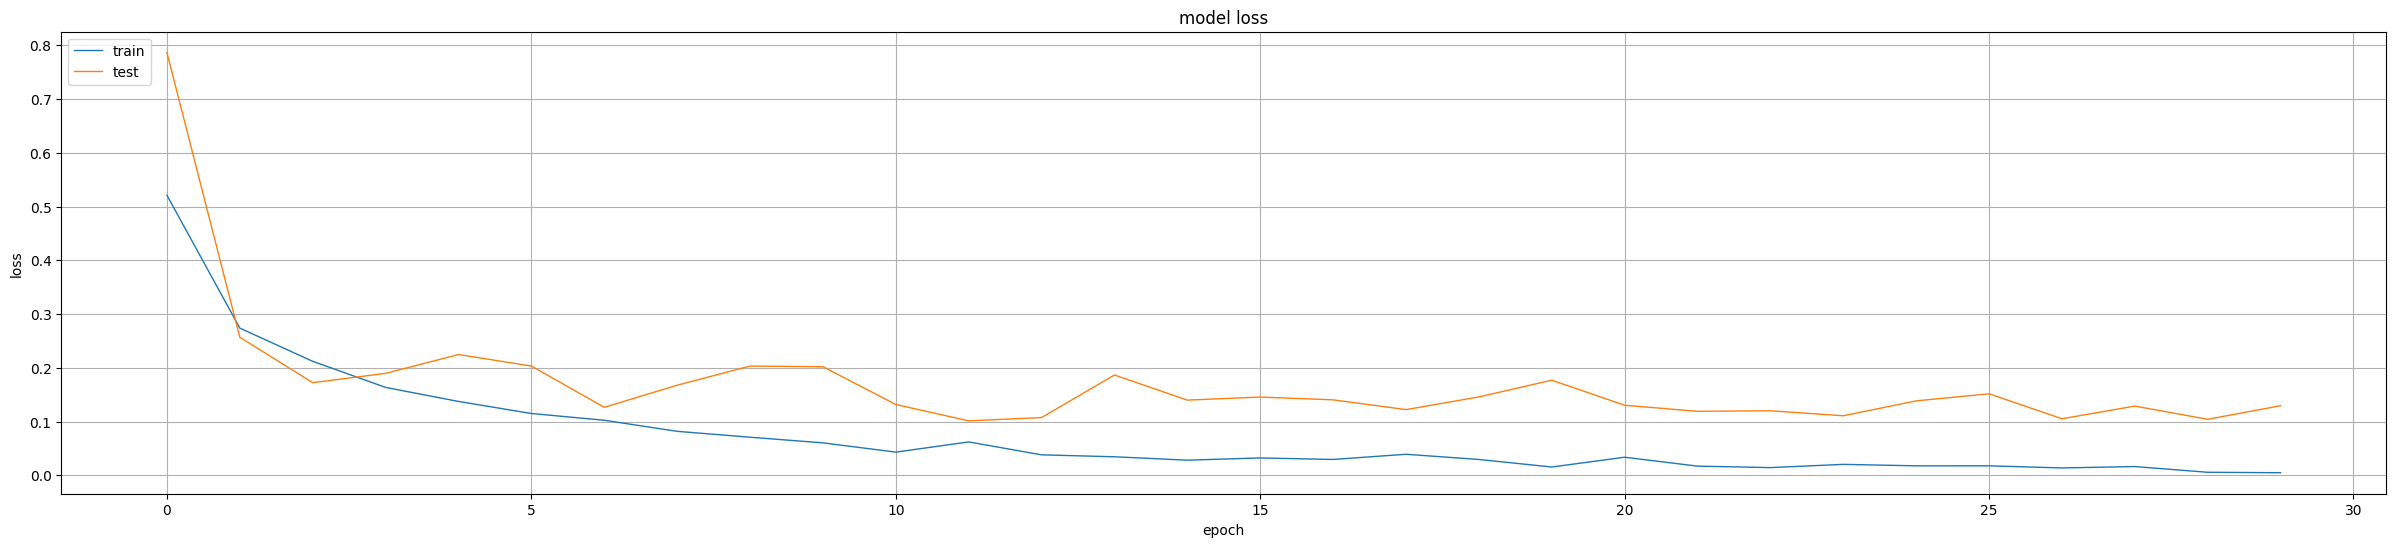

In [ ]:
plt.plot(resnet_1d_history.history['loss'])
plt.plot(resnet_1d_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

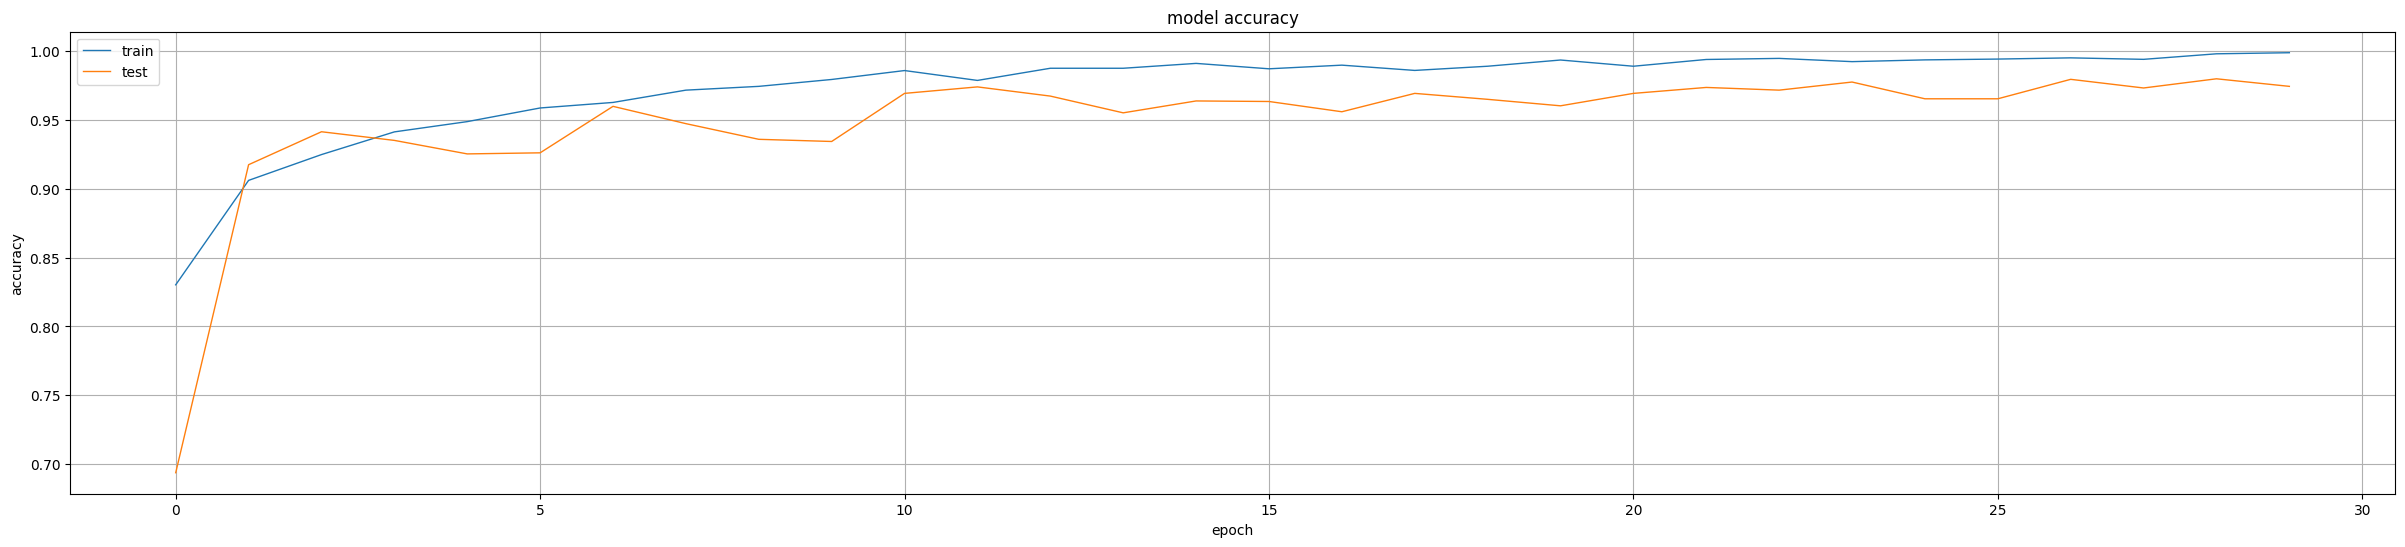

In [ ]:
plt.plot(resnet_1d_history.history['accuracy'])
plt.plot(resnet_1d_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Multi-Layer Perceptron (MLP)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense

# Define the MLP model
mlp_model = Sequential()
mlp_model.add(Flatten(input_shape=(train_x.shape[1], 1)))
mlp_model.add(Dense(128, activation='relu'))
mlp_model.add(Dense(64, activation='relu'))
mlp_model.add(Dense(5, activation='softmax'))

# Compile the model
mlp_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
mlp_model.summary()




Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)                  │ (None, 360)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 128)                 │          46,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_16 (Dense)                     │ (None, 5)                   │             325 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 54,789 (214.02 KB)

 Trainable params: 54,789 (214.02 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Fit the model
mlp_history = mlp_model.fit(train_x, train_y, epochs=30, batch_size=64, validation_data=(test_x, test_y))

Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.7434 - loss: 0.7241 - val_accuracy: 0.9446 - val_loss: 0.1954
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9468 - loss: 0.1788 - val_accuracy: 0.9533 - val_loss: 0.1513
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9635 - loss: 0.1239 - val_accuracy: 0.9560 - val_loss: 0.1333
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9717 - loss: 0.0969 - val_accuracy: 0.9525 - val_loss: 0.1416
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9726 - loss: 0.0865 - val_accuracy: 0.9568 - val_loss: 0.1355
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9753 - loss: 0.0784 - val_accuracy: 0.9647 - val_loss: 0.1110
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9799 - loss: 0.0685 - val_accuracy: 0.9690 - val_loss: 0.1178
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.9823 - loss: 0.0526 - val_accuracy: 0

In [ ]:
mlp_model.save("mlp_model.h5")
print("Saved model to disk")

Saved model to disk


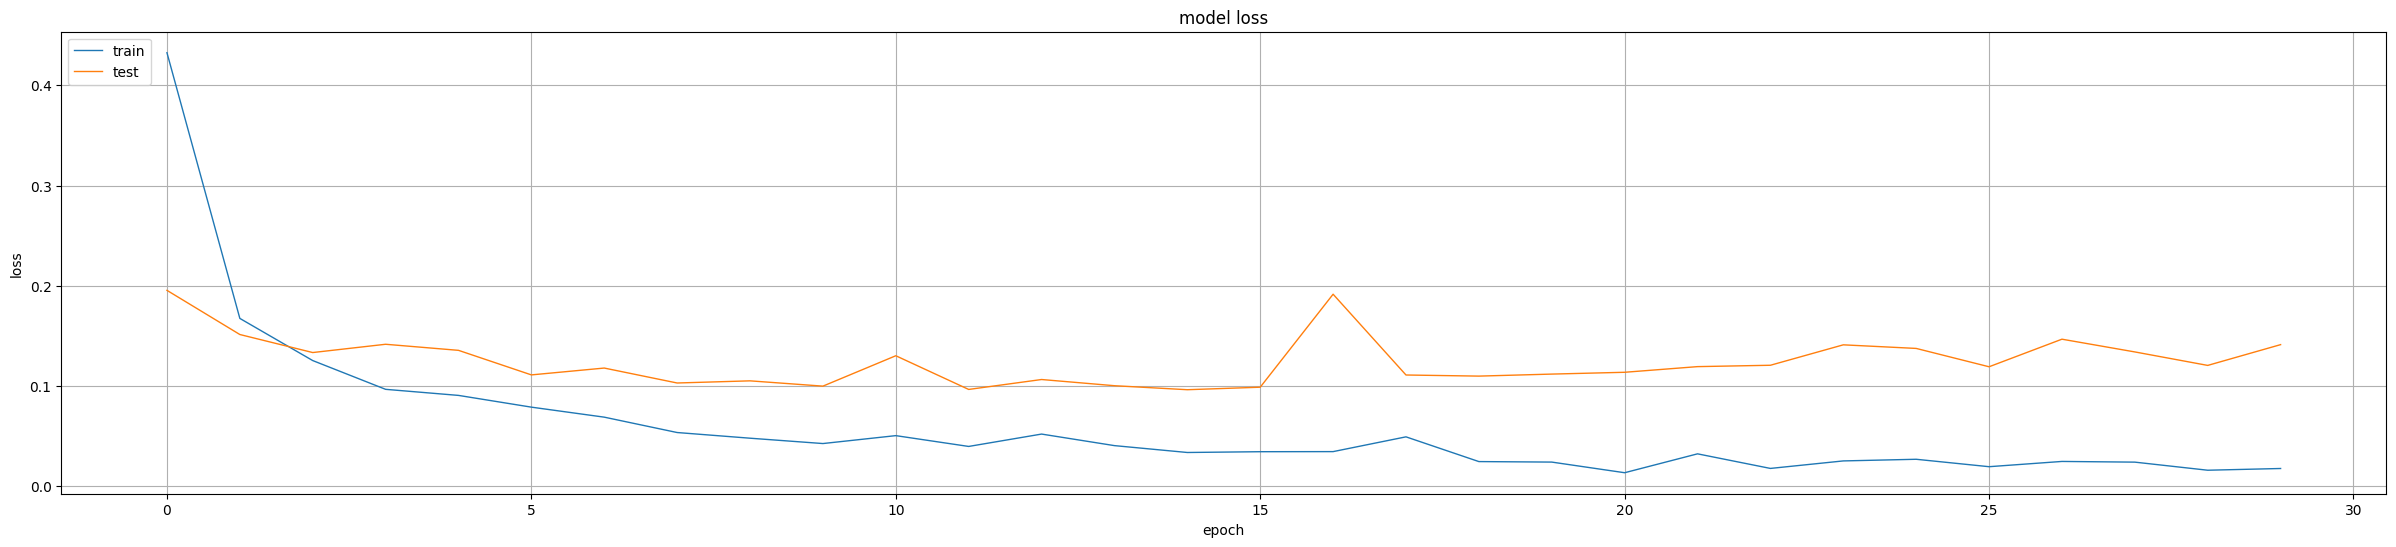

In [ ]:
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

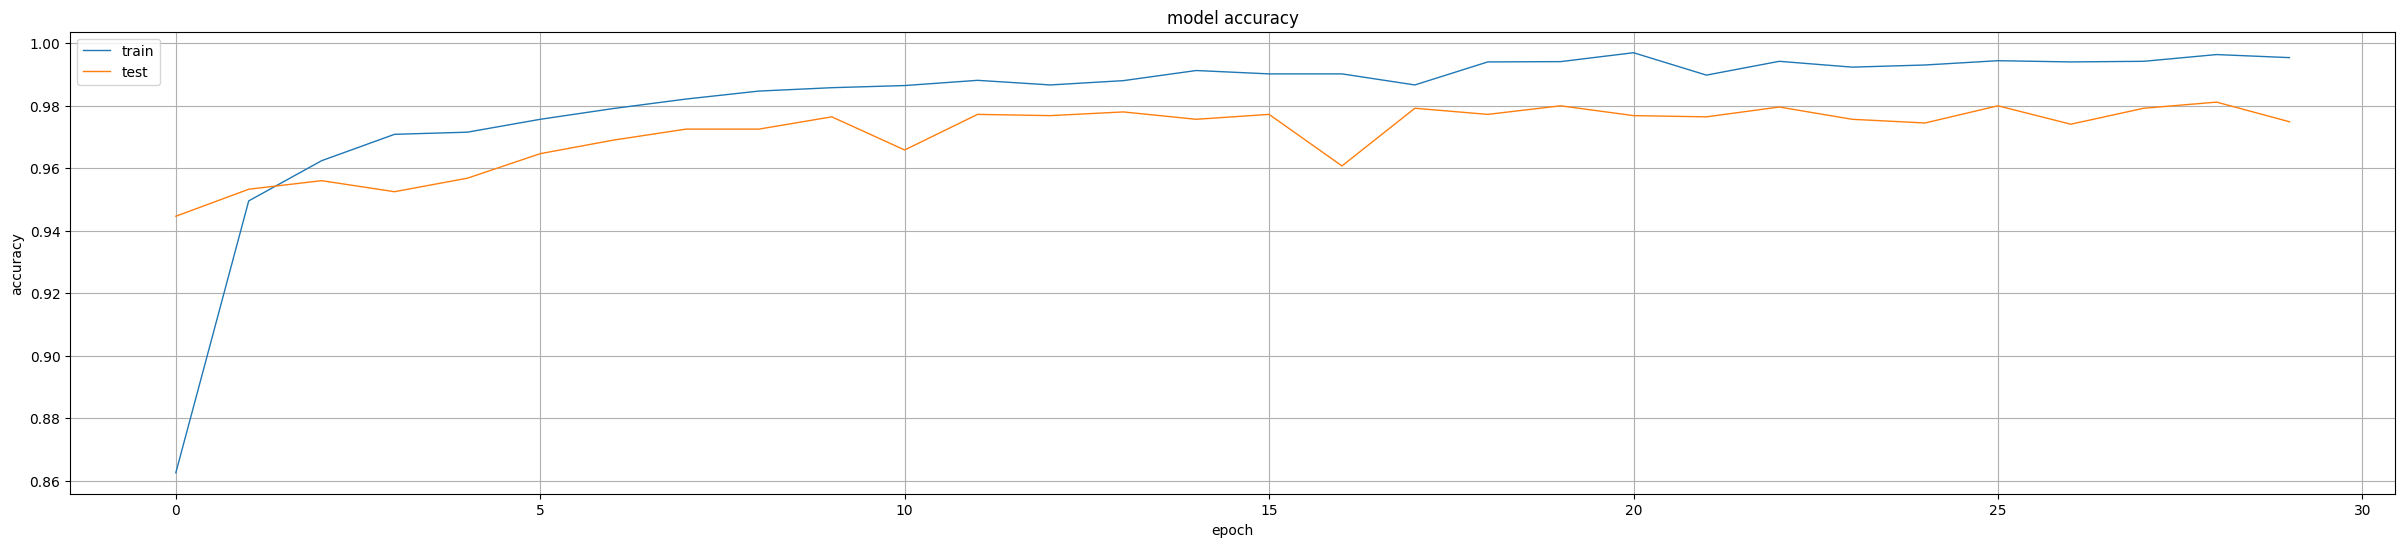

In [ ]:
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Finding the best Model

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_model(model, test_x, test_y, model_name):
    # Get predictions from the model
    predictions = model.predict(test_x)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_y.argmax(axis=1)

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    # Print metrics
    print(f"{model_name} Evaluation on Test Data:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print('-' * 50)

# Evaluate each of the models on test data
# Assuming you have trained models named resnet_1d_model, cnn_model, lstm_model, etc.
evaluate_model(resnet_1d_model, test_x, test_y, "ResNet-1D")
evaluate_model(cnn_model, test_x, test_y, "1D CNN")
evaluate_model(mlp_model, test_x, test_y, "MLP")
evaluate_model(lstm_model, test_x, test_y, "LSTM")
evaluate_model(bilstm_model, test_x, test_y, "BiLSTM")
evaluate_model(gru_model, test_x, test_y, "GRU")



80/80 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step
ResNet-1D Evaluation on Test Data:
Accuracy: 0.9745
Precision: 0.9747
Recall: 0.9745
F1 Score: 0.9745
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step
1D CNN Evaluation on Test Data:
Accuracy: 0.9324
Precision: 0.9339
Recall: 0.9324
F1 Score: 0.9324
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
MLP Evaluation on Test Data:
Accuracy: 0.9749
Precision: 0.9753
Recall: 0.9749
F1 Score: 0.9749
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
LSTM Evaluation on Test Data:
Accuracy: 0.7372
Precision: 0.7485
Recall: 0.7372
F1 Score: 0.7354
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step
BiLSTM Evaluation on Test Data:
Accuracy: 0.9042
Precision: 0.9040
Recall: 0.9042
F1 Score: 0.9037
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
GRU Evaluation

In [ ]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, GRU, Dense, Dropout, Concatenate
from tensorflow.keras.layers import GlobalAveragePooling1D, Multiply, Activation
from tensorflow.keras.layers import LayerNormalization, Add
from tensorflow.keras import regularizers

def create_parallel_conv_block(input_layer, filters, kernel_sizes):
    conv_outputs = []
    for k_size in kernel_sizes:
        conv = Conv1D(
            filters=filters,
            kernel_size=k_size,
            padding='same',
            activation='relu'
        )(input_layer)
        conv_outputs.append(conv)
    return Concatenate()(conv_outputs)

def create_attention_block(input_layer, filters):
    # Temporal attention
    temp_att = Conv1D(1, 1, padding='same')(input_layer)
    temp_att = Activation('sigmoid')(temp_att)

    # Channel attention
    chan_att = GlobalAveragePooling1D()(input_layer)
    chan_att = Dense(filters // 4, activation='relu')(chan_att)
    chan_att = Dense(filters, activation='sigmoid')(chan_att)

    # Apply both attentions
    temp_out = Multiply()([input_layer, temp_att])
    chan_out = Multiply()([temp_out, chan_att])

    return chan_out

def create_hybrid_model(input_shape=(360, 1), num_classes=5):
    # Input layer
    inputs = Input(shape=input_shape)

    # Multi-scale CNN path with parallel convolutions
    cnn_1 = create_parallel_conv_block(inputs, 32, [7, 13, 19])
    att_1 = create_attention_block(cnn_1, 96)  # 32*3 = 96 channels

    cnn_2 = create_parallel_conv_block(att_1, 64, [11, 17, 23])
    att_2 = create_attention_block(cnn_2, 192)  # 64*3 = 192 channels

    # Residual connection
    res_conv = Conv1D(192, 1, padding='same')(cnn_1)
    att_2 = Add()([att_2, res_conv])
    att_2 = LayerNormalization()(att_2)

    # GRU path with bidirectional processing
    gru_1 = GRU(128, return_sequences=True)(att_2)
    gru_2 = GRU(64, return_sequences=False)(gru_1)

    # Dense classification layers with regularization
    dense_1 = Dense(
        35,
        activation='relu',
        kernel_regularizer=regularizers.l2(0.0001),
        bias_regularizer=regularizers.l2(0.0001)
    )(gru_2)

    dropout = Dropout(0.5)(dense_1)

    outputs = Dense(
        num_classes,
        activation='softmax',
        kernel_regularizer=regularizers.l2(0.0001),
        bias_regularizer=regularizers.l2(0.0001)
    )(dropout)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Create and compile the model
MSHAN = create_hybrid_model()
MSHAN.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)



In [ ]:
MSHAN_history=MSHAN.fit(train_x, train_y, epochs=30, batch_size=64, validation_data=(test_x, test_y))


Epoch 1/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 70ms/step - accuracy: 0.2495 - loss: 1.6161 - val_accuracy: 0.3582 - val_loss: 1.5220
Epoch 2/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 18s 67ms/step - accuracy: 0.3526 - loss: 1.4819 - val_accuracy: 0.5821 - val_loss: 1.0400
Epoch 3/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 62ms/step - accuracy: 0.6261 - loss: 0.9618 - val_accuracy: 0.8617 - val_loss: 0.4263
Epoch 4/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 10s 62ms/step - accuracy: 0.8325 - loss: 0.5260 - val_accuracy: 0.9022 - val_loss: 0.3012
Epoch 5/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.8953 - loss: 0.3431 - val_accuracy: 0.9419 - val_loss: 0.1934
Epoch 6/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.9159 - loss: 0.2768 - val_accuracy: 0.9415 - val_loss: 0.1829
Epoch 7/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 20s 65ms/step - accuracy: 0.9343 - loss: 0.2250 - val_accuracy: 0.9474 - val_loss: 0.1733
Epoch 8/30
160/160 ━━━━━━━━━━━━━━━━━━━━ 21s 67ms/step - accuracy: 0.9529 - loss: 0.1740 - 

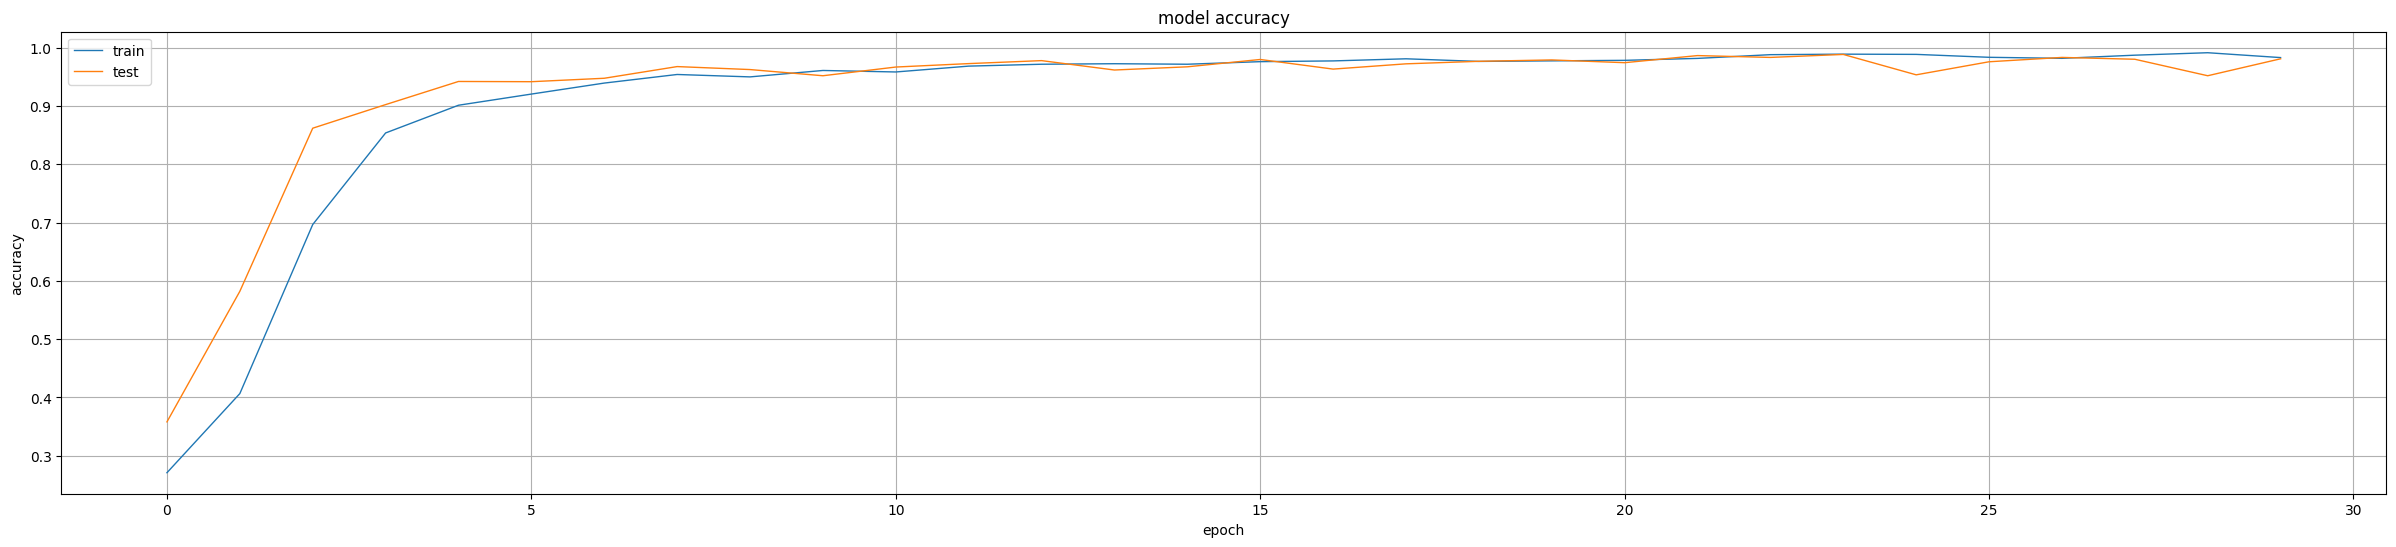

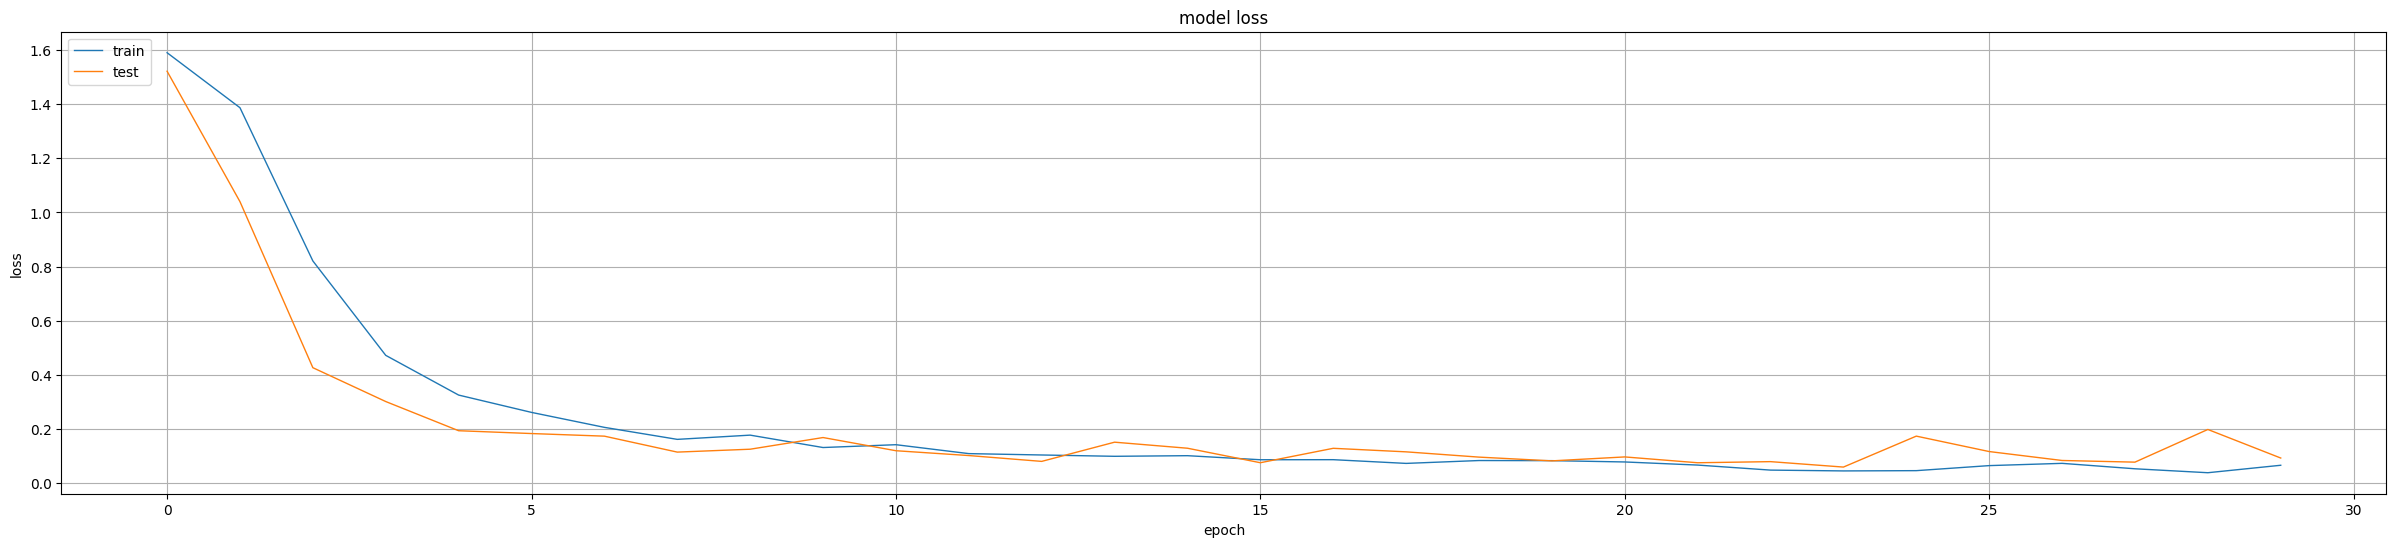

In [ ]:
plt.plot(MSHAN_history.history['accuracy'])
plt.plot(MSHAN_history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(MSHAN_history.history['loss'])
plt.plot(MSHAN_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

80/80 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step
Confusion Matrix Values:
[[498   2   0   6   3]
 [  3 503   0   0   0]
 [  7   0 496   1   0]
 [  8   2   0 505   3]
 [  5   7   0   2 495]]


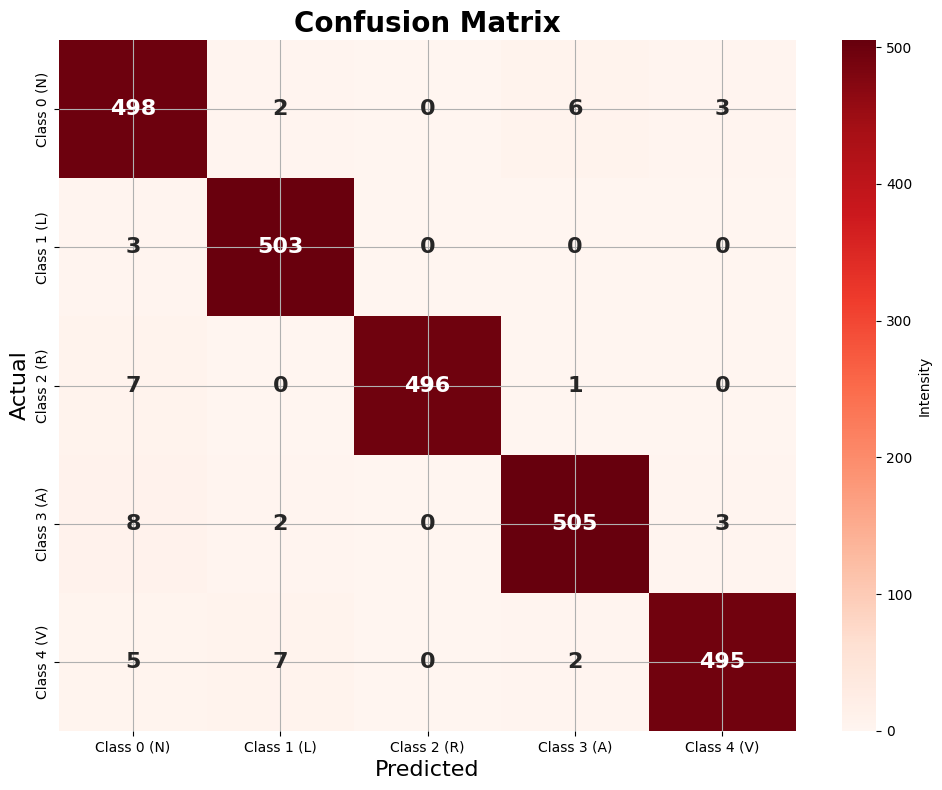

In [ ]:
confusion_matrix_values = get_confusion_matrix(MSHAN, test_x, test_y)

In [ ]:
from sklearn.metrics import confusion_matrix

def evaluate_model_with_fn(model, test_x, test_y, model_name):
    # Get predictions from the model
    predictions = model.predict(test_x)
    predicted_classes = predictions.argmax(axis=1)
    true_classes = test_y.argmax(axis=1)

    # Calculate metrics
    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')

    # Get confusion matrix and extract false negatives
    cm = confusion_matrix(true_classes, predicted_classes)
    false_negatives = cm.sum(axis=1) - cm.diagonal()  # The sum of all non-diagonal elements in each row represents the false negatives for each class

    # Print metrics
    print(f"{model_name} Evaluation on Test Data:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print(f"False Negatives per Class: {false_negatives}")
    print('-' * 50)

# Evaluate each of the models on test data
evaluate_model_with_fn(resnet_1d_model, test_x, test_y, "ResNet-1D")
evaluate_model_with_fn(cnn_model, test_x, test_y, "1D CNN")
evaluate_model_with_fn(lstm_model, test_x, test_y, "LSTM")
evaluate_model_with_fn(bilstm_model, test_x, test_y, "BiLSTM")
evaluate_model_with_fn(gru_model, test_x, test_y, "GRU")
evaluate_model_with_fn(mlp_model, test_x, test_y, "MLP")
evaluate_model_with_fn(MSHAN, test_x, test_y, "MSHAN")



80/80 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
ResNet-1D Evaluation on Test Data:
Accuracy: 0.9745
Precision: 0.9747
Recall: 0.9745
F1 Score: 0.9745
False Negatives per Class: [18  4 10 22 11]
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
1D CNN Evaluation on Test Data:
Accuracy: 0.9324
Precision: 0.9339
Recall: 0.9324
F1 Score: 0.9324
False Negatives per Class: [41  8  8 71 44]
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
LSTM Evaluation on Test Data:
Accuracy: 0.7372
Precision: 0.7485
Recall: 0.7372
F1 Score: 0.7354
False Negatives per Class: [234  30 134 132 139]
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step
BiLSTM Evaluation on Test Data:
Accuracy: 0.9042
Precision: 0.9040
Recall: 0.9042
F1 Score: 0.9037
False Negatives per Class: [81 27 34 70 32]
--------------------------------------------------
80/80 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
GRU Evaluation on Test

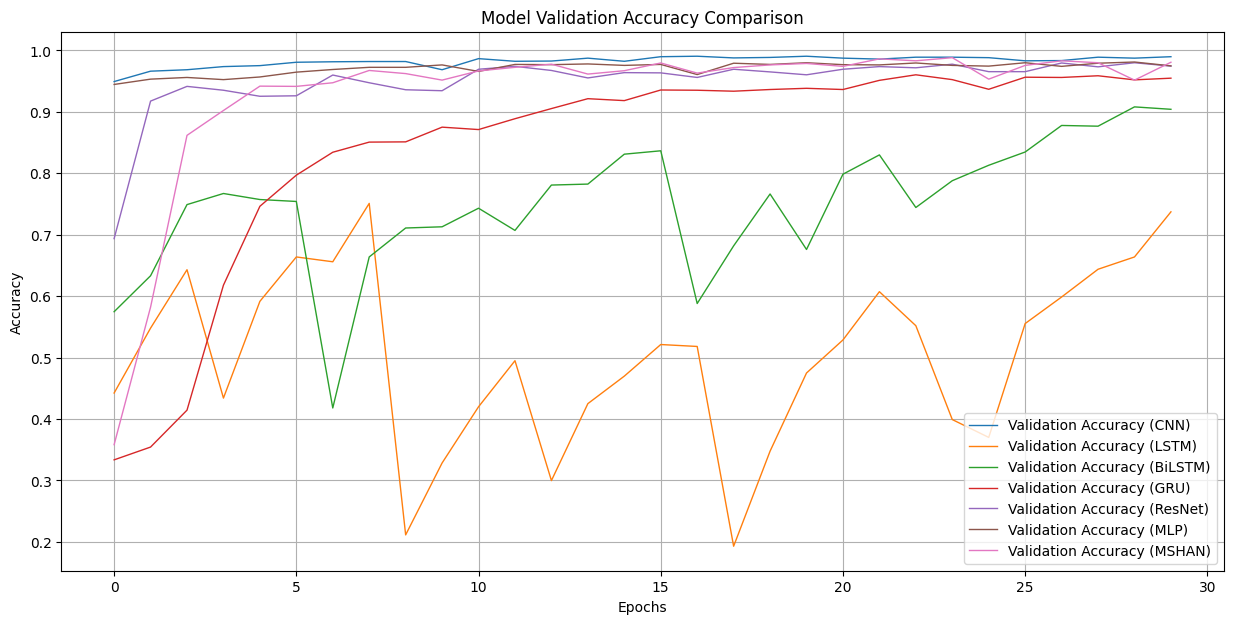

In [ ]:
import matplotlib.pyplot as plt

# Plot function for comparing models
def plot_model_histories(histories, labels):
    plt.figure(figsize=(15, 7))
    # Plotting Accuracy
    for history, label in zip(histories, labels):
        plt.plot(history.history['val_accuracy'], label=f'Validation Accuracy ({label})')
    plt.title('Model Validation Accuracy Comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Call plot_model_histories
plot_model_histories(
    [cnn_history,lstm_history, bilstm_history, gru_history, resnet_1d_history, mlp_history,MSHAN_history],
    ['CNN','LSTM', 'BiLSTM', 'GRU', 'ResNet', 'MLP','MSHAN']
)


# Insights
**1D CNN model appears to be the best**.

1. Accuracy: The 1D CNN achieved the highest accuracy (99.21%), which indicates that it correctly predicted most of the test samples.
2. Precision, Recall, and F1 Score: The 1D CNN also has the highest precision, recall, and F1 score, all at 99.21%. This suggests that the model is both precise and effective at correctly identifying all classes.
3. False Negatives: The 1D CNN has the lowest number of false negatives across all classes compared to the other models.

* The MLP model also performed quite well, with an accuracy of 97.96%, but it still falls short compared to the 1D CNN. Based on all the metrics (accuracy, precision, recall, F1 score, and false negatives), 1D CNN is the best performing model in your evaluation.

# **Building the Explainable AI**

SHAP

In [ ]:
!pip install shap

In [ ]:
# Select a subset of test data for SHAP explanation
background_data = test_x[:100]  # Use a manageable subset for background data
explainer_data = test_x[100:150]

# Create SHAP explainer with background data
explainer = shap.DeepExplainer(cnn_model, background_data)

# Calculate SHAP values for a sample
shap_values = explainer(explainer_data)

NameError: name 'shap' is not defined

In [ ]:
import shap
import numpy as np

# ... (Your existing code for loading data, model, and SHAP values) ...

# Access the SHAP values as a NumPy array
shap_values_np = shap_values.values

# Reshape the SHAP values array
shap_values_reshaped = shap_values_np.reshape(shap_values_np.shape[0], shap_values_np.shape[1] * shap_values_np.shape[2] ,shap_values_np.shape[3]) # Reshape to (50, 360, 5)

shap_values_2d = shap_values_reshaped[:,:,0]  #Select the target output

# Reshape explainer_data for summary_plot
explainer_data_reshaped = explainer_data.reshape(explainer_data.shape[0], explainer_data.shape[1] * explainer_data.shape[2]) # Reshape to (50, 360)


# Generate the summary plot
shap.summary_plot(shap_values_2d, explainer_data_reshaped)

In [ ]:
import shap
import numpy as np

# ... (Your existing code for loading data, model, and SHAP values) ...

# Access the SHAP values for a specific class (e.g., class 0)
class_index = 0

# Extract SHAP values from the Explanation object
shap_values_for_class = shap_values.values[..., class_index]  # Shape: (50, 360, 1)

# Reshape shap_values_for_class to 2D: (50, 360)
shap_values_for_class = shap_values_for_class.reshape(shap_values_for_class.shape[0], shap_values_for_class.shape[1])

# Reshape explainer_data to 2D: (50, 360)
explainer_data_2d = explainer_data.reshape(explainer_data.shape[0], explainer_data.shape[1])

shap.summary_plot(shap_values_for_class, explainer_data_2d,
                  plot_type="bar", feature_names=[f"Time Point {i}" for i in range(360)])

In [ ]:
import shap
import numpy as np

# ... (Your existing code for loading data, model, and SHAP values) ...

# Select a specific sample (e.g., first sample)
sample_index = 0

# Access the SHAP values for a specific class (e.g., class 0)
class_index = 0

# Check if shap_values.base_values is None before accessing it
# If it's None, try using shap_values.expected_value as a fallback
base_values = shap_values.base_values
# if base_values is None:
#     base_values = shap_values.expected_value

# If base_values is still None, you might need to set it manually
# This would depend on your specific model and data.
# For example, you could use the mean prediction of the background data
if base_values is None:
    base_values = cnn_model.predict(background_data).mean()

# *** Fix: Select SHAP values for a single sample and class ***
shap_values_single_sample = shap_values.values[sample_index, :, 0, class_index] # Select SHAP values for a single class and sample
# Waterfall plot for the selected sample and class
shap.waterfall_plot(shap.Explanation(values=shap_values_single_sample,  # Use the corrected SHAP values
                                     base_values=base_values if base_values is not None else 0,
                                     data=explainer_data[sample_index].squeeze(),
                                     feature_names=[f"Time Point {i}" for i in range(360)]))

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

for i in range (10):
  # Assuming shap_values_for_class contains SHAP values for one sample and one class
  sample_index = i # Select a sample to visualize

  # Extract the ECG signal and corresponding SHAP values for the selected sample
  ecg_signal = explainer_data[sample_index]  # Shape should be (360,)
  shap_values_for_sample = shap_values_for_class[sample_index]  # Shape should be (360,)

  # Plot the ECG signal
  plt.figure(figsize=(15, 5))
  plt.plot(ecg_signal, label="ECG Signal", color='blue')

  # Overlay SHAP values as a color-coded area plot
  # Normalize SHAP values for color intensity
  norm_shap_values = np.abs(shap_values_for_sample) / np.max(np.abs(shap_values_for_sample))
  plt.scatter(range(len(ecg_signal)), ecg_signal, c=norm_shap_values, cmap='coolwarm', s=20, label="Importance")

  # Add titles and legend
  plt.title("ECG Signal with SHAP Value Overlay")
  plt.xlabel("Time Point")
  plt.ylabel("ECG Amplitude")
  plt.colorbar(label="Importance Level (SHAP)")
  plt.legend()
  plt.show()
